#  Bias







In [2]:
import gensim
from gensim import utils
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Task 1: Train Two Models

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load and Process Datasets</b> 
</div>

First, you need to add [this](https://www.kaggle.com/datasets/julianschelb/newsdata) news dataset to your notebook. Click on "+Add data" and the dataset. In the first task, you will load and filter the data. Please implement the following steps:

1. Load the data by reading the csv files.
2. Filter all entries in the *relevant_entities.json* file containing entity labels referring to one of the politicians indicated in below list. Also define a list of 3-5 countries which you want to include in the task  (*Hint:* you need to use the 'label' or 'norm' key (Wikipedia QID for entity label) here).
3. From the resulting list of entities, use the first 50000 entries and select all sentences containing these entities (*Hint:* you need to match entities and sentences based on the 'docID' **and** 'sendocID' key. Also remove line breaks in the sentences if necessary. This step might require ~30-45 minutes runtime.

In [3]:
# Read article data
with open("../input/newsdata/relevant_articles.json","rb") as d:
    articles = json.load(d)
    
# Read entity data (we need Wikidata QID for given words)
with open("../input/newsdata/relevant_entities.json","rb") as d:
    entities = json.load(d)

# Read sentence data
with open("../input/newsdata/sentences_matched_entities.json","rb") as d:
    sentences = json.load(d)

In [4]:
# Pre-defined list of US politicians
persons = ['Donald Trump','Hillary Clinton','Bernie Sanders','David Cameron','Vladimir Putin']

# Define list of countries
countries = ["Q43", "Q145", "Q142", "Q31", "Q183"]

In [5]:
# Get all entity entries whose labels match with any word from given lists
filtered_entities = [entity for entity in entities if entity.get('label') in persons or entity.get('norm') in countries]
print(len(filtered_entities))

447796


In [8]:
# Identify the sentences which correspond to the first 50000
filtered_entities = filtered_entities[:50000]

In [9]:

filtered_entities_dict = {(entity['docID'], entity['senDocID']): entity for entity in filtered_entities}

matched_sentences = []
matched_identifiers = set()

for sentence in sentences:
    id = sentence['docID']
    sendoc_id = sentence['senDocID']


    sentence_identifier = (id, sendoc_id)


    if sentence_identifier not in matched_identifiers:

        entity = filtered_entities_dict.get(sentence_identifier)


        if entity is not None:
            matched_identifiers.add(sentence_identifier)
            matched_sentences.append(sentence)
for matched in matched_sentences:
    matched['text'].replace('\n', ' ')

print(matched_sentences[:2])
print(len(matched_sentences))
print(type(matched_sentences))
print(matched_sentences[1]['text'])

lists = [a['text'] for a in matched_sentences]
print(lists[0])



[{'_id': 1145457, 'docID': 197727, 'senDocID': 2, 'text': 'My fellow housing and economics journalists have been wailing like Cassandra for years now, but last year, it was rare to flip through a newspaper without seeing a headline addressing the utter madness of the UK’s housing market.'}, {'_id': 1145459, 'docID': 197727, 'senDocID': 4, 'text': 'But a new year is an opportunity for a fresh start; here are five new year’s resolutions for Britain’s housing crisis.'}]
40198
<class 'list'>
But a new year is an opportunity for a fresh start; here are five new year’s resolutions for Britain’s housing crisis.
My fellow housing and economics journalists have been wailing like Cassandra for years now, but last year, it was rare to flip through a newspaper without seeing a headline addressing the utter madness of the UK’s housing market.


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Categorize News Articles</b> 
</div>

In the second step, we ask you to assign the sentences obtained in Step 1 to a "conservative" and "liberal" set of sentences. Please implement the following to pre-process the data:

* Based on the indicated list of conservative and liberal news outlets, assign the sentences to a "conservative" and "liberal" set of sentences (*Hint:* You need the 'feed' key from the article file as well as the '_id' key (article file) and 'docID' (sentences) to match sentences with articles.

In [10]:
# List of conservative and liberal news outlets according to Allsides.com
cons_outlets = ['telegraph','Fox']
liberal_outlets = ['guardian','cbs','HuffingtonUS','WP','HuffingtonUK','Atlantic']

In [11]:
# Filter sentences according to conservative and liberal leaning of articles
cons = []
lib = []
cons_outlets_set = set(cons_outlets)
liberal_outlets_set = set(liberal_outlets)

article_identifiers = {article.get('_id'): article.get('feed') for article in articles}

for sentence in matched_sentences:
    sentence_id = sentence.get('docID')

    if sentence_id is not None:
        # Check if the sentence corresponds to an article
        if sentence_id in article_identifiers:
            feed = article_identifiers[sentence_id]


            # Categorize the sentence based on the news outlet
            if feed in cons_outlets_set:
                cons.append(sentence)
            elif feed in liberal_outlets_set:
                lib.append(sentence)
cons_list = [cons_sent['text'] for cons_sent in cons] # needs to be done for training
lib_list = [lib_sent['text'] for lib_sent in lib]


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Model Training</b> 
</div>

The third step covers model training. Please implement the following step:
* Use the code from last week's assignment to train a Word2Vec model over 40 epochs separately on the conservative and liberal sets of sentences.

In [12]:
class MyCorpus():
    def __init__(self, words):
        self.words = words

    def __iter__(self):
            for word in self.words: # Assume there's one document per line, tokens separated by whitespace
                yield utils.simple_preprocess(word)

In [13]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim import utils
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.losses = []
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.losses.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            self.losses.append(loss-self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss

In [14]:
# Train conservative model
cons_corpus = MyCorpus(cons_list)

In [15]:
from gensim.models import Word2Vec

# Assuming cons_corpus is a list of tokenized sentences

# Instantiate the LossLogger callback
loss_logger = callback()

# Build vocabulary
w2v_model_cons = Word2Vec(min_count=5,
                     window=5,
                     workers=4,
                     sg=1)


# build vocab
w2v_model_cons.build_vocab(cons_corpus)

# train the w2v model
w2v_model_cons.train(cons_corpus,
                total_examples=w2v_model_cons.corpus_count,
                epochs=40,
                compute_loss=True,  # set compute_loss = True
                callbacks=[loss_logger])  # add the callback class


Loss after epoch 0: 914185.3125
Loss after epoch 1: 811137.8125
Loss after epoch 2: 784681.625
Loss after epoch 3: 675505.0
Loss after epoch 4: 744916.75
Loss after epoch 5: 678057.0
Loss after epoch 6: 632527.0
Loss after epoch 7: 622053.5
Loss after epoch 8: 616700.0
Loss after epoch 9: 543783.5
Loss after epoch 10: 605450.0
Loss after epoch 11: 604734.0
Loss after epoch 12: 544455.5
Loss after epoch 13: 519245.0
Loss after epoch 14: 519939.0
Loss after epoch 15: 516526.0
Loss after epoch 16: 510716.0
Loss after epoch 17: 515986.0
Loss after epoch 18: 509697.0
Loss after epoch 19: 506199.0
Loss after epoch 20: 504723.0
Loss after epoch 21: 502552.0
Loss after epoch 22: 439929.0
Loss after epoch 23: 501598.0
Loss after epoch 24: 501629.0
Loss after epoch 25: 500480.0
Loss after epoch 26: 504615.0
Loss after epoch 27: 499533.0
Loss after epoch 28: 489562.0
Loss after epoch 29: 428906.0
Loss after epoch 30: 426998.0
Loss after epoch 31: 377896.0
Loss after epoch 32: 423282.0
Loss after 

(4858343, 7125480)

In [16]:
w2v_model_cons.save("cons_model.h5")

In [17]:
# Train liberal model
lib_corpus = MyCorpus(lib_list)

In [18]:
from gensim.models import Word2Vec

# Assuming cons_corpus is a list of tokenized sentences

# Instantiate the LossLogger callback
loss_logger = callback()

# Build vocabulary
w2v_model_lib = Word2Vec(min_count=5,
                     window=5,
                     workers=4,
                     sg=1)


# build vocab
w2v_model_lib.build_vocab(lib_corpus)

# train the w2v model
w2v_model_lib.train(lib_corpus,
                total_examples=w2v_model_lib.corpus_count,
                epochs=40,
                compute_loss=True,  # set compute_loss = True
                callbacks=[loss_logger])  # add the callback class

Loss after epoch 0: 3084439.25
Loss after epoch 1: 2562647.75
Loss after epoch 2: 2371816.5
Loss after epoch 3: 2051813.5
Loss after epoch 4: 1781615.0
Loss after epoch 5: 1970443.0
Loss after epoch 6: 1769720.0
Loss after epoch 7: 1756671.0
Loss after epoch 8: 1849810.0
Loss after epoch 9: 1610268.0
Loss after epoch 10: 1715920.0
Loss after epoch 11: 1647794.0
Loss after epoch 12: 1641422.0
Loss after epoch 13: 1693150.0
Loss after epoch 14: 1575808.0
Loss after epoch 15: 1855268.0
Loss after epoch 16: 1567084.0
Loss after epoch 17: 1383934.0
Loss after epoch 18: 957452.0
Loss after epoch 19: 1010776.0
Loss after epoch 20: 866552.0
Loss after epoch 21: 944276.0
Loss after epoch 22: 904212.0
Loss after epoch 23: 911092.0
Loss after epoch 24: 954364.0
Loss after epoch 25: 982040.0
Loss after epoch 26: 781548.0
Loss after epoch 27: 877960.0
Loss after epoch 28: 966340.0
Loss after epoch 29: 900580.0
Loss after epoch 30: 899084.0
Loss after epoch 31: 926628.0
Loss after epoch 32: 897424.0

(19107871, 26203040)

In [21]:
w2v_model_lib.save("lib_model.h5")

## Task 2: Compare Both Models

We ask you to find the k-nearest neighbours (= k most similar words by cosine distance) in both the conservative and liberal model for every politician/country indicated in our list and visualize/interpret the results. Please implement the following steps:

* Get the k-nearest neighbors (try k=20 or k=30) for every politician/country and both models.
* Apply Principal Component Analysis (PCA) to reduce dimensionality (with number of components = 2) and plot the results for every politician and his/her k-nearest neighbors.
* Show the ranked similarities for every politician/country in a table with descending similarity.
* Interpret the results: can you see any differences between the conservative and liberal model? If yes, briefly elaborate on the differences you observe. If not, briefly discuss possible shortcomings of the approach.

In [20]:
def get_k_nearest_neighbors(word, model, k):
    similar_words = model.wv.most_similar(word, topn=k)
    return [word for word, _ in similar_words]

def get_k_nearest_neighbors_person(word, model, k):
    word = word.lower().split()
    similar_words = model.wv.most_similar([word[0], word[1]], topn=k)
    return [word for word, _ in similar_words]

def apply_pca(data):
    pca = PCA(n_components=2)
    pca.fit(data)
    embeddings_transformed = pca.transform(data)
    return embeddings_transformed

def plot_pca(embeddings, labels, title):


    plt.rcParams["figure.figsize"] = (20,15)


    for i, label in enumerate(labels):
        plt.scatter(embeddings[i, 0], embeddings[i, 1], c='blue', alpha=0.3)
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]))


    plt.title(title)
    plt.show()

def calculate_cosine_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]



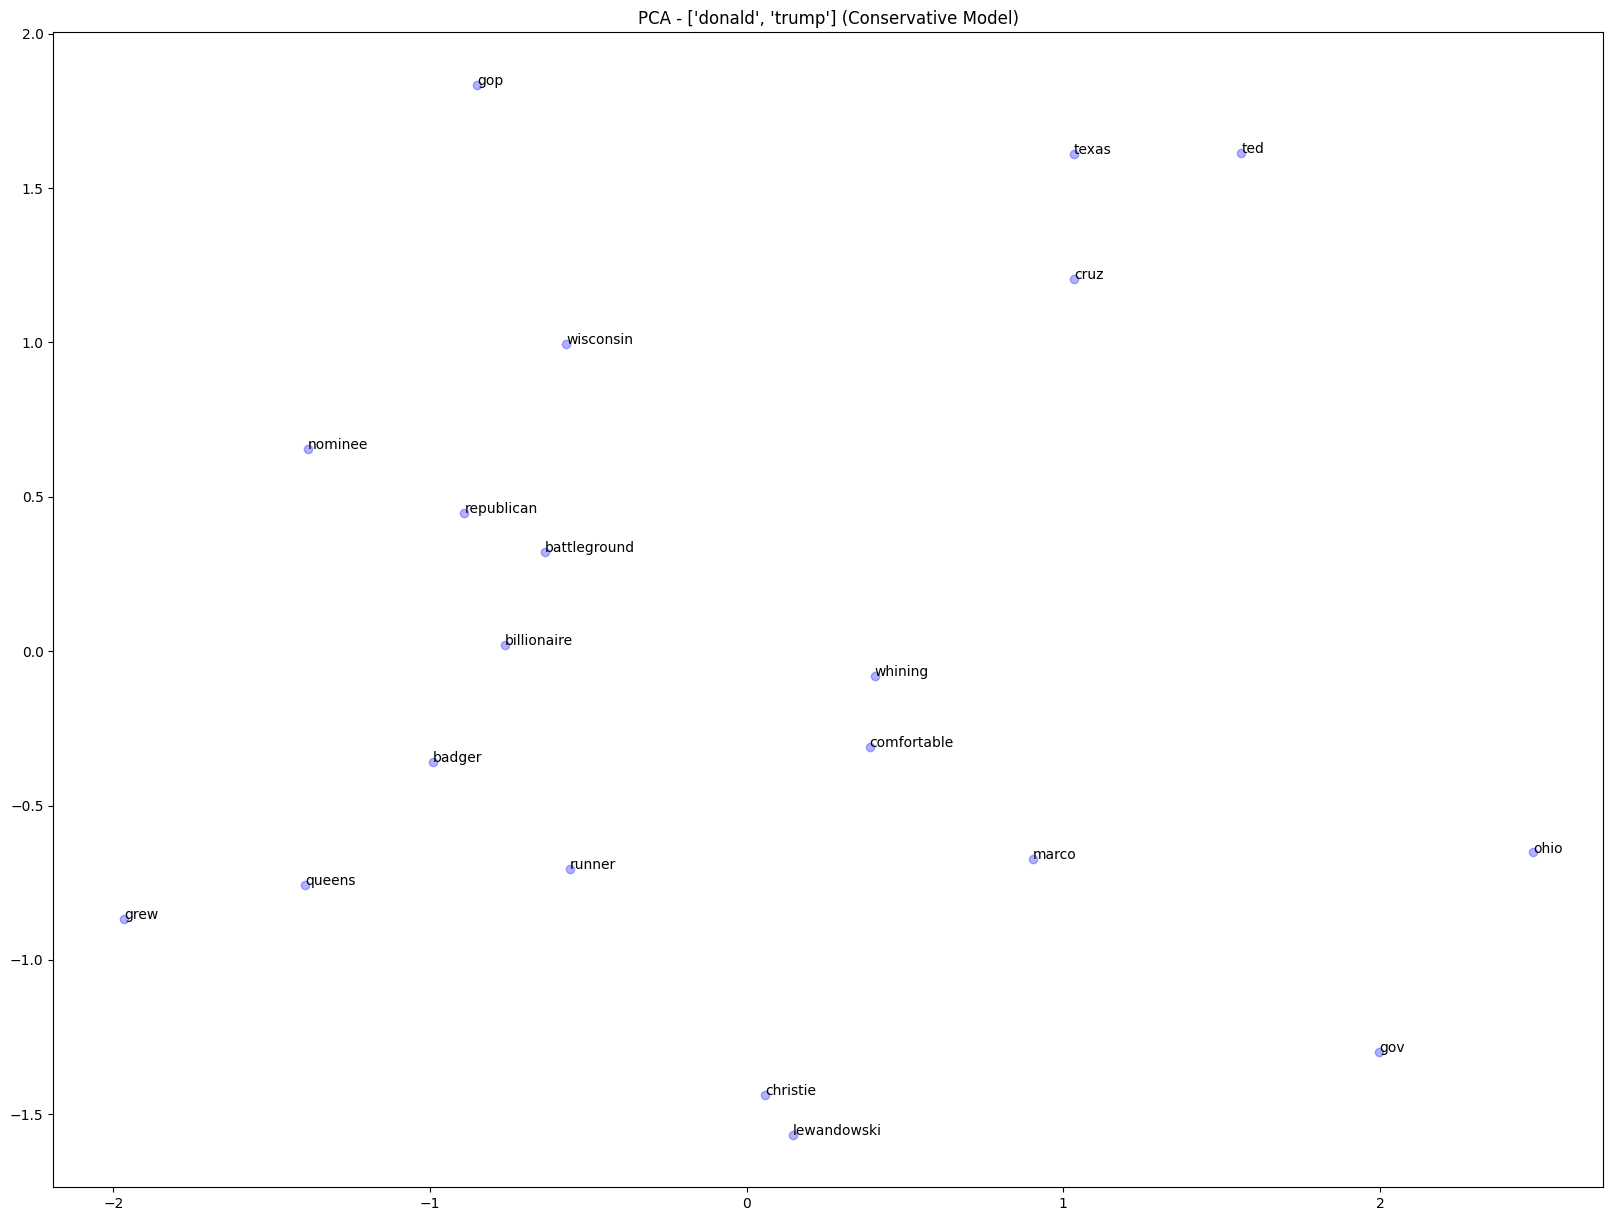

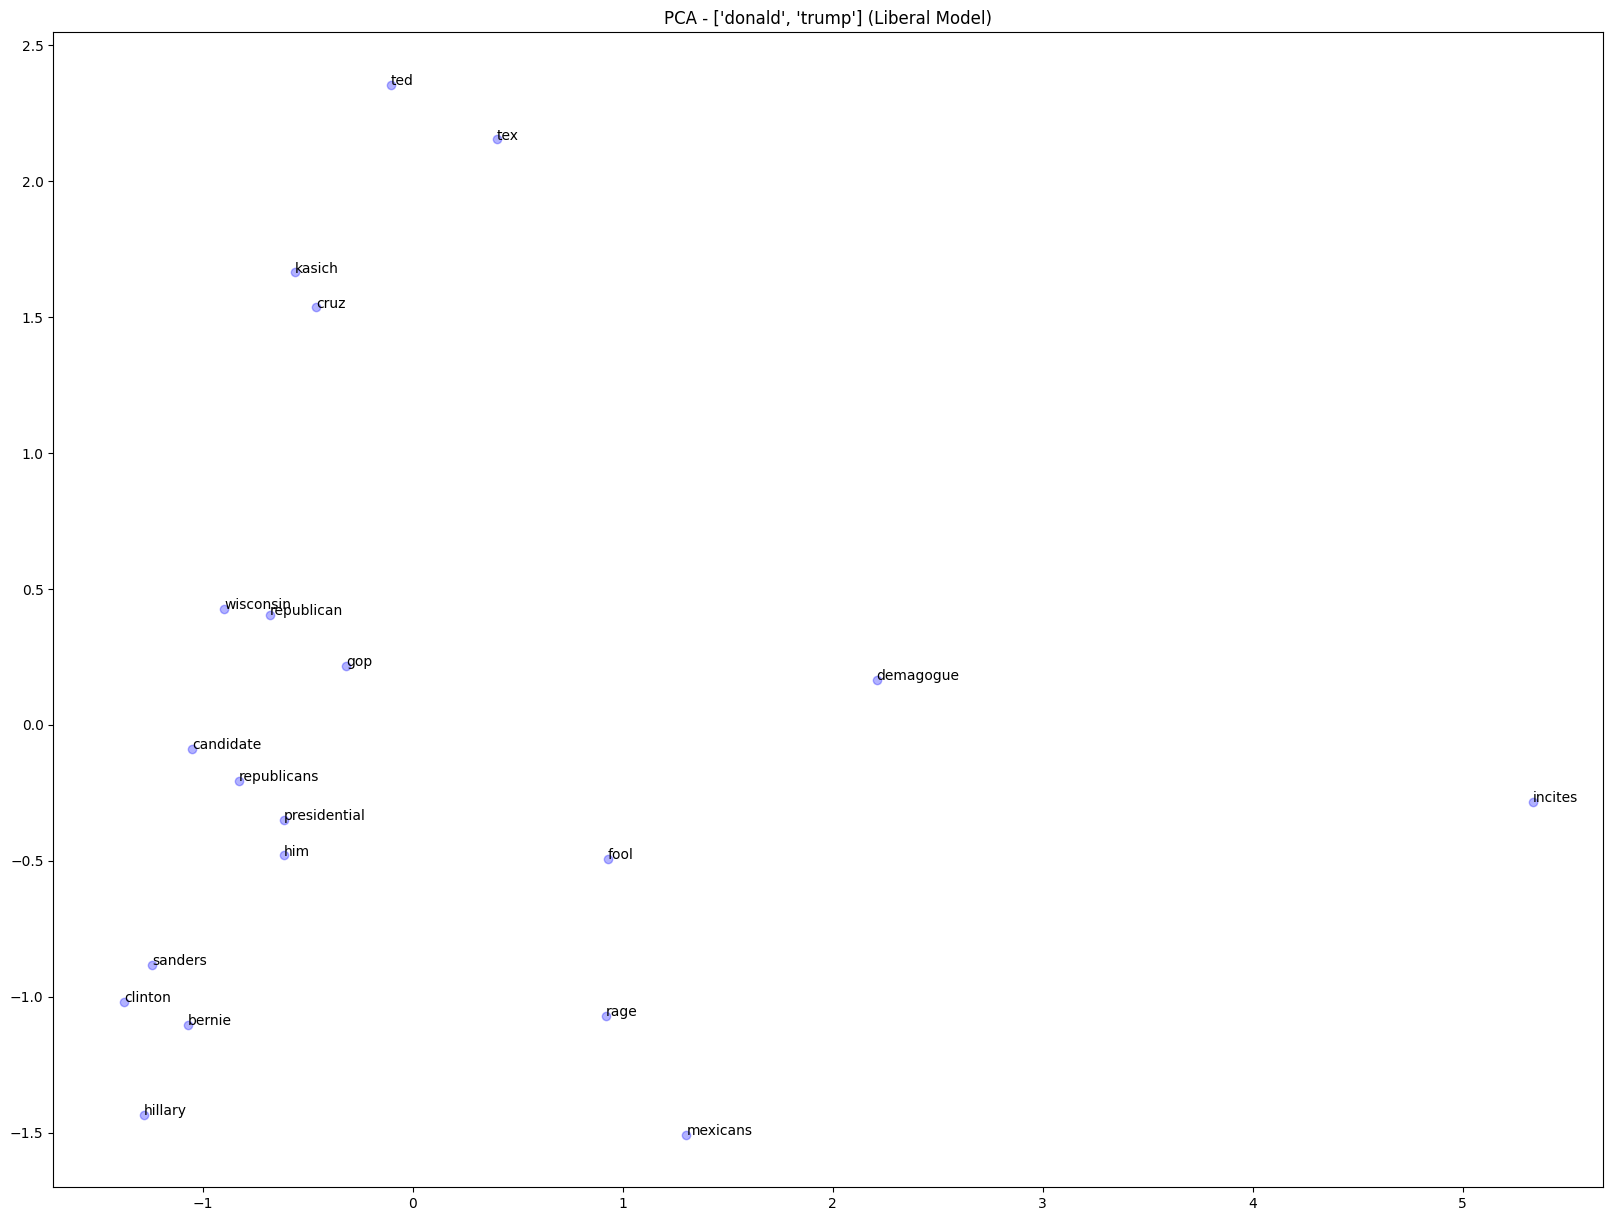

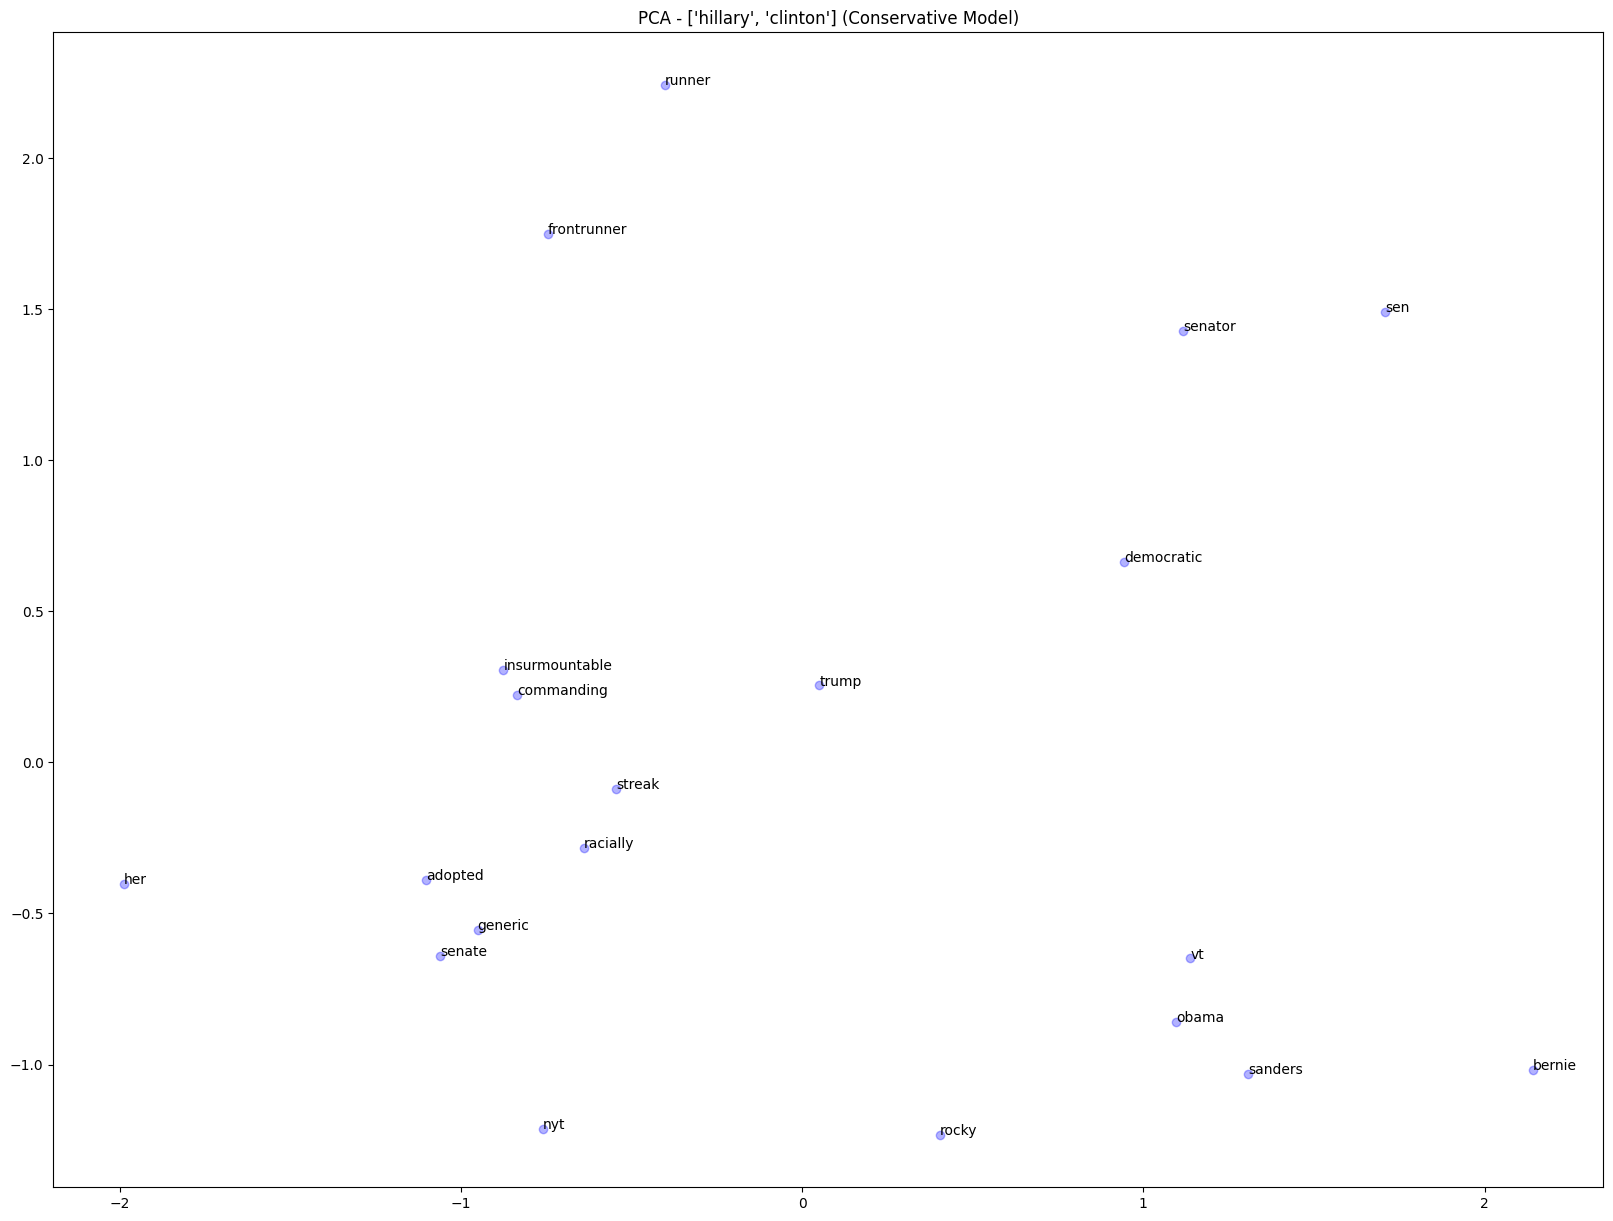

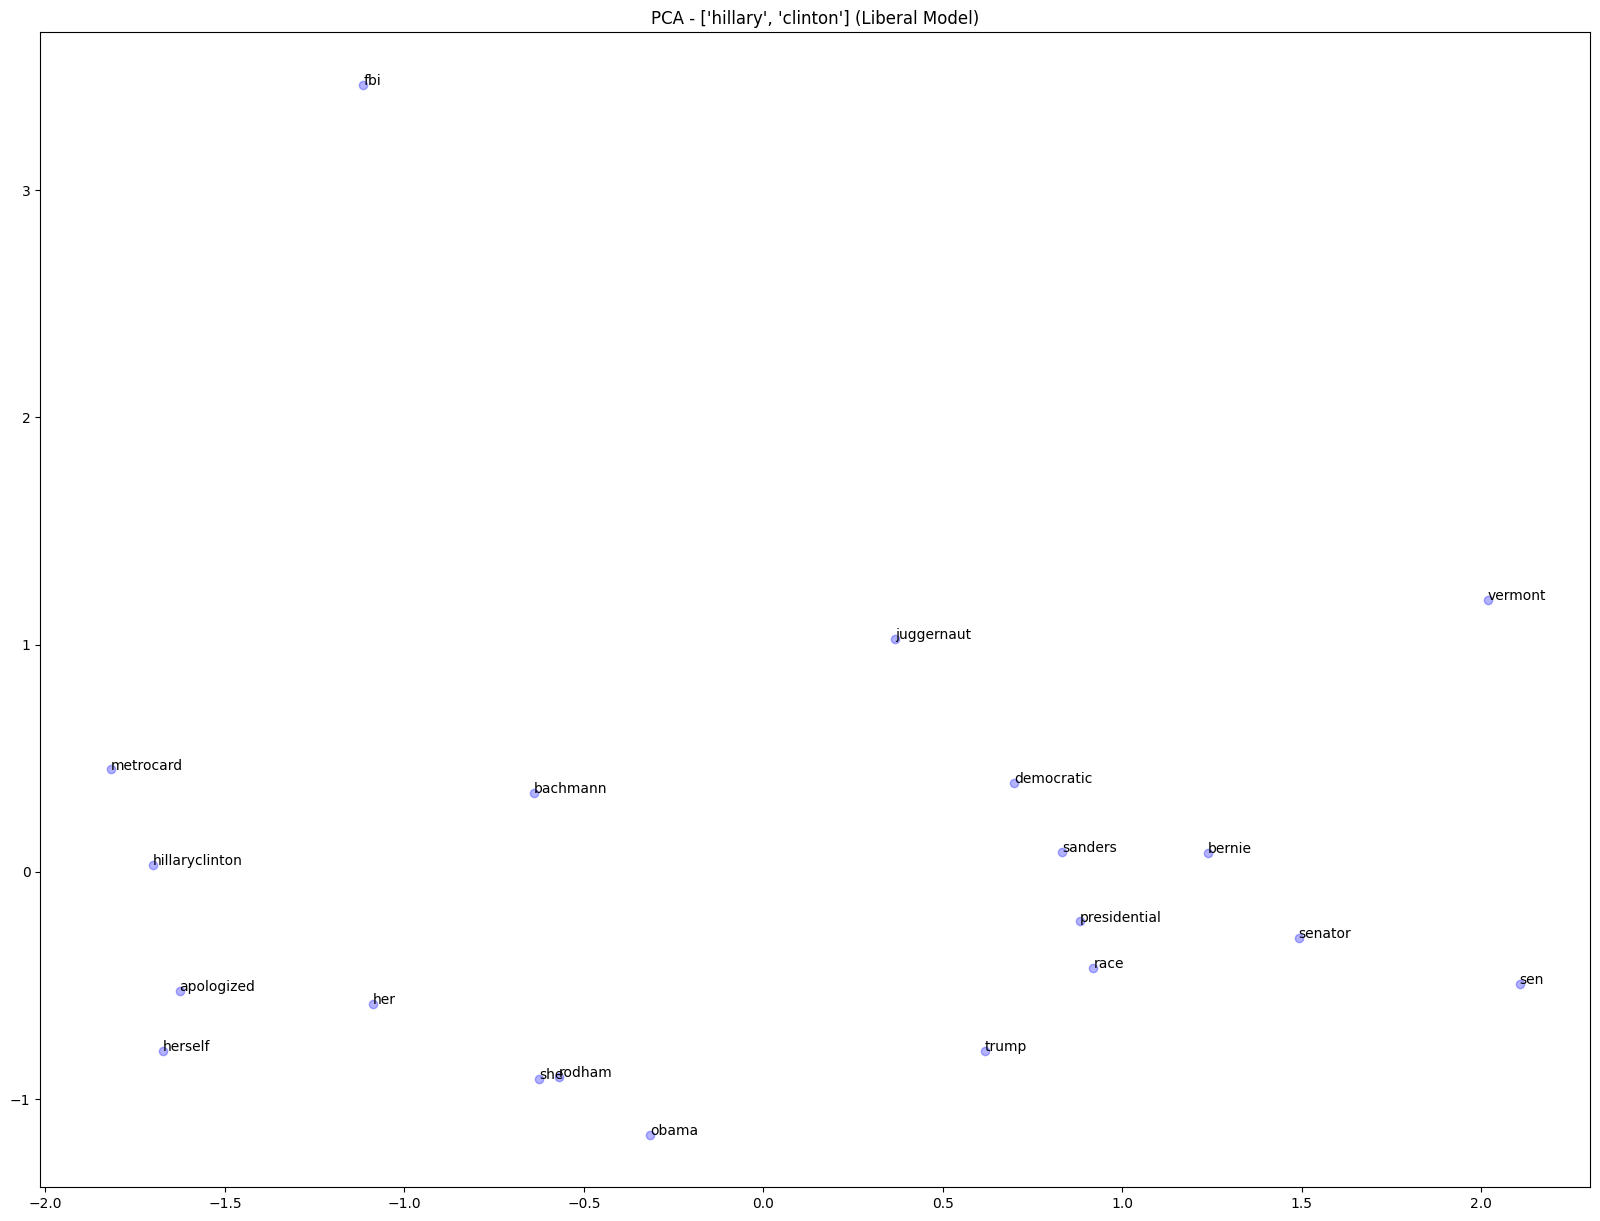

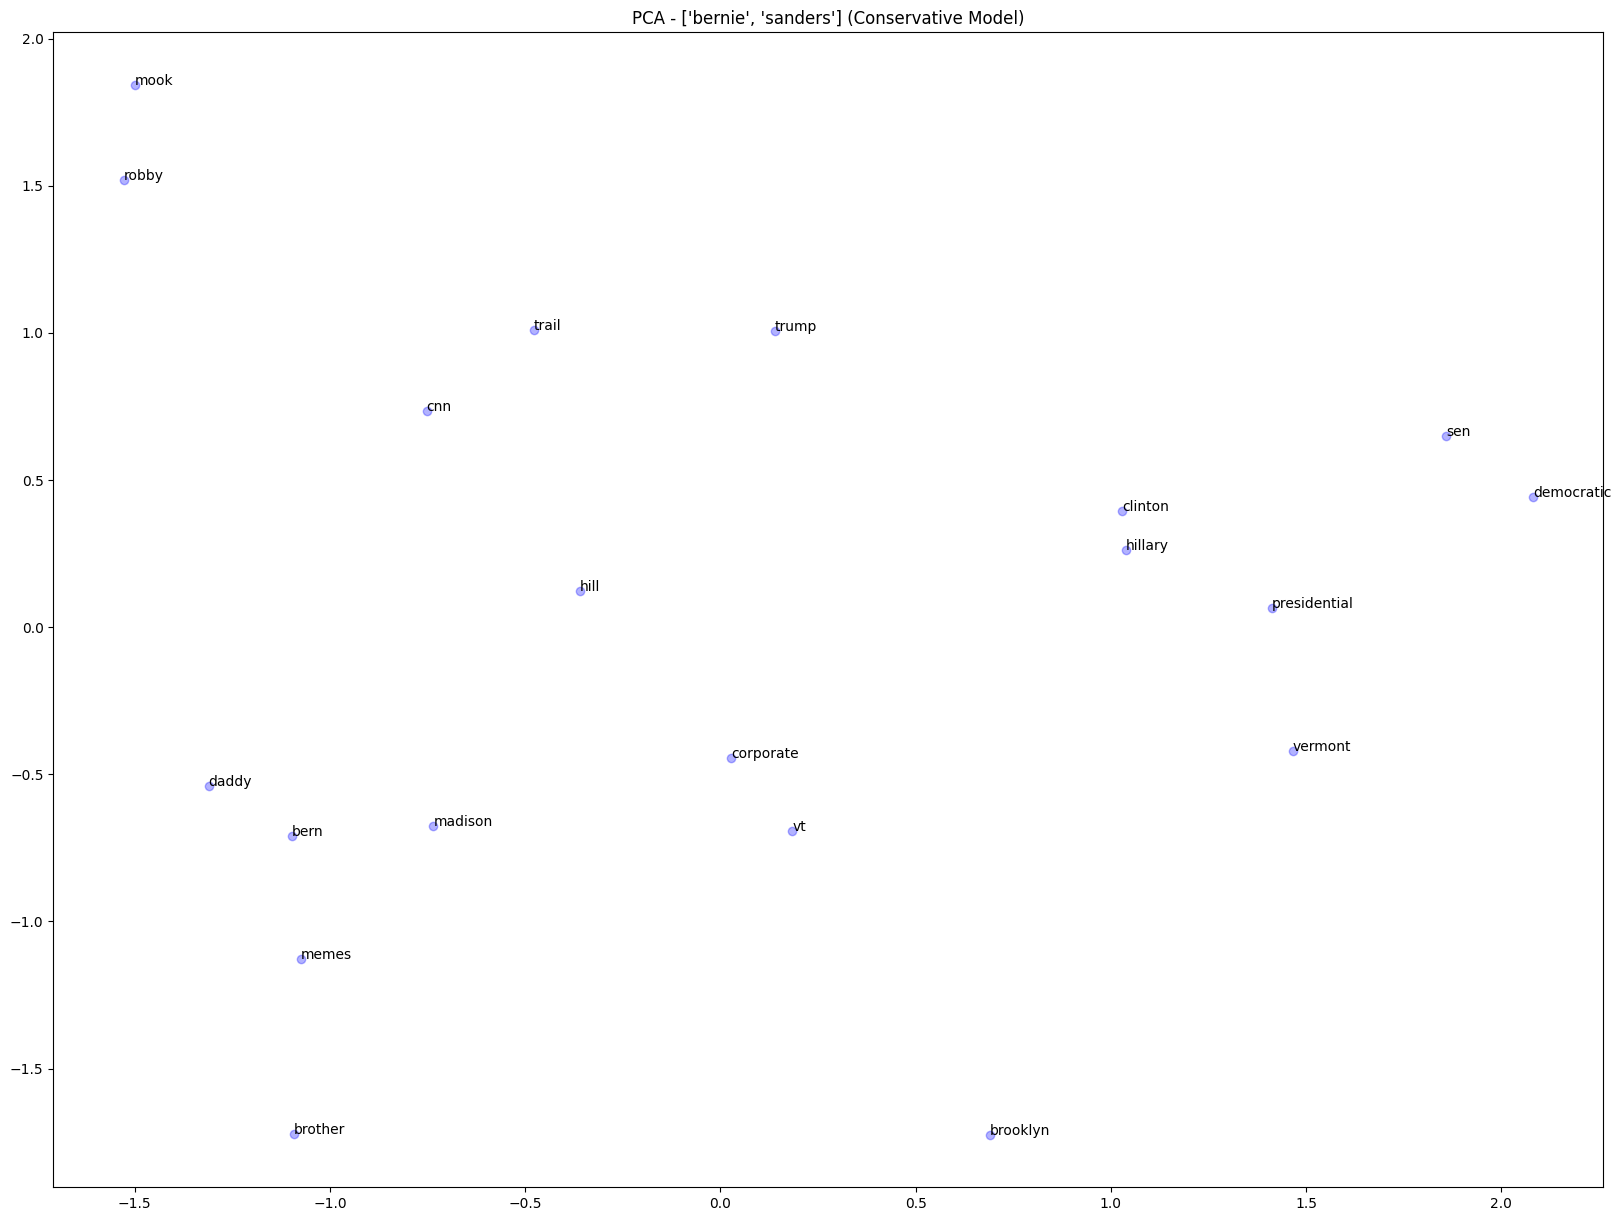

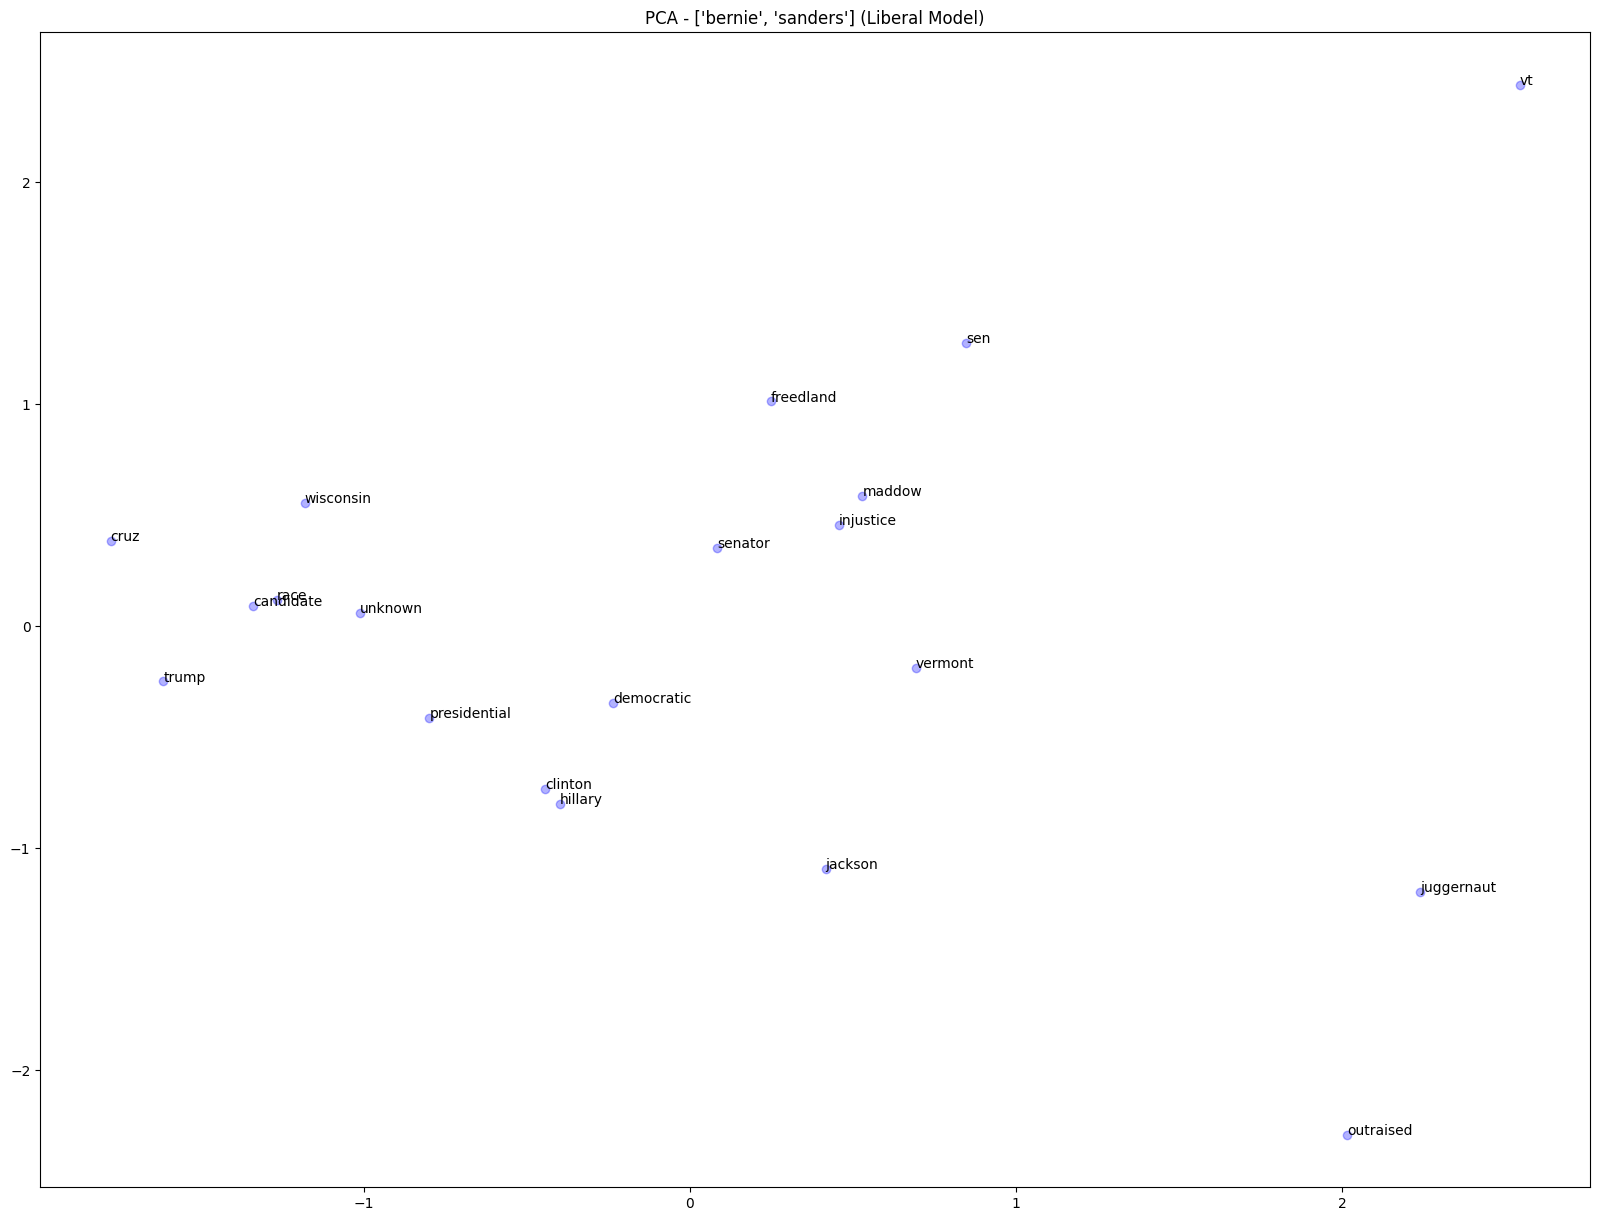

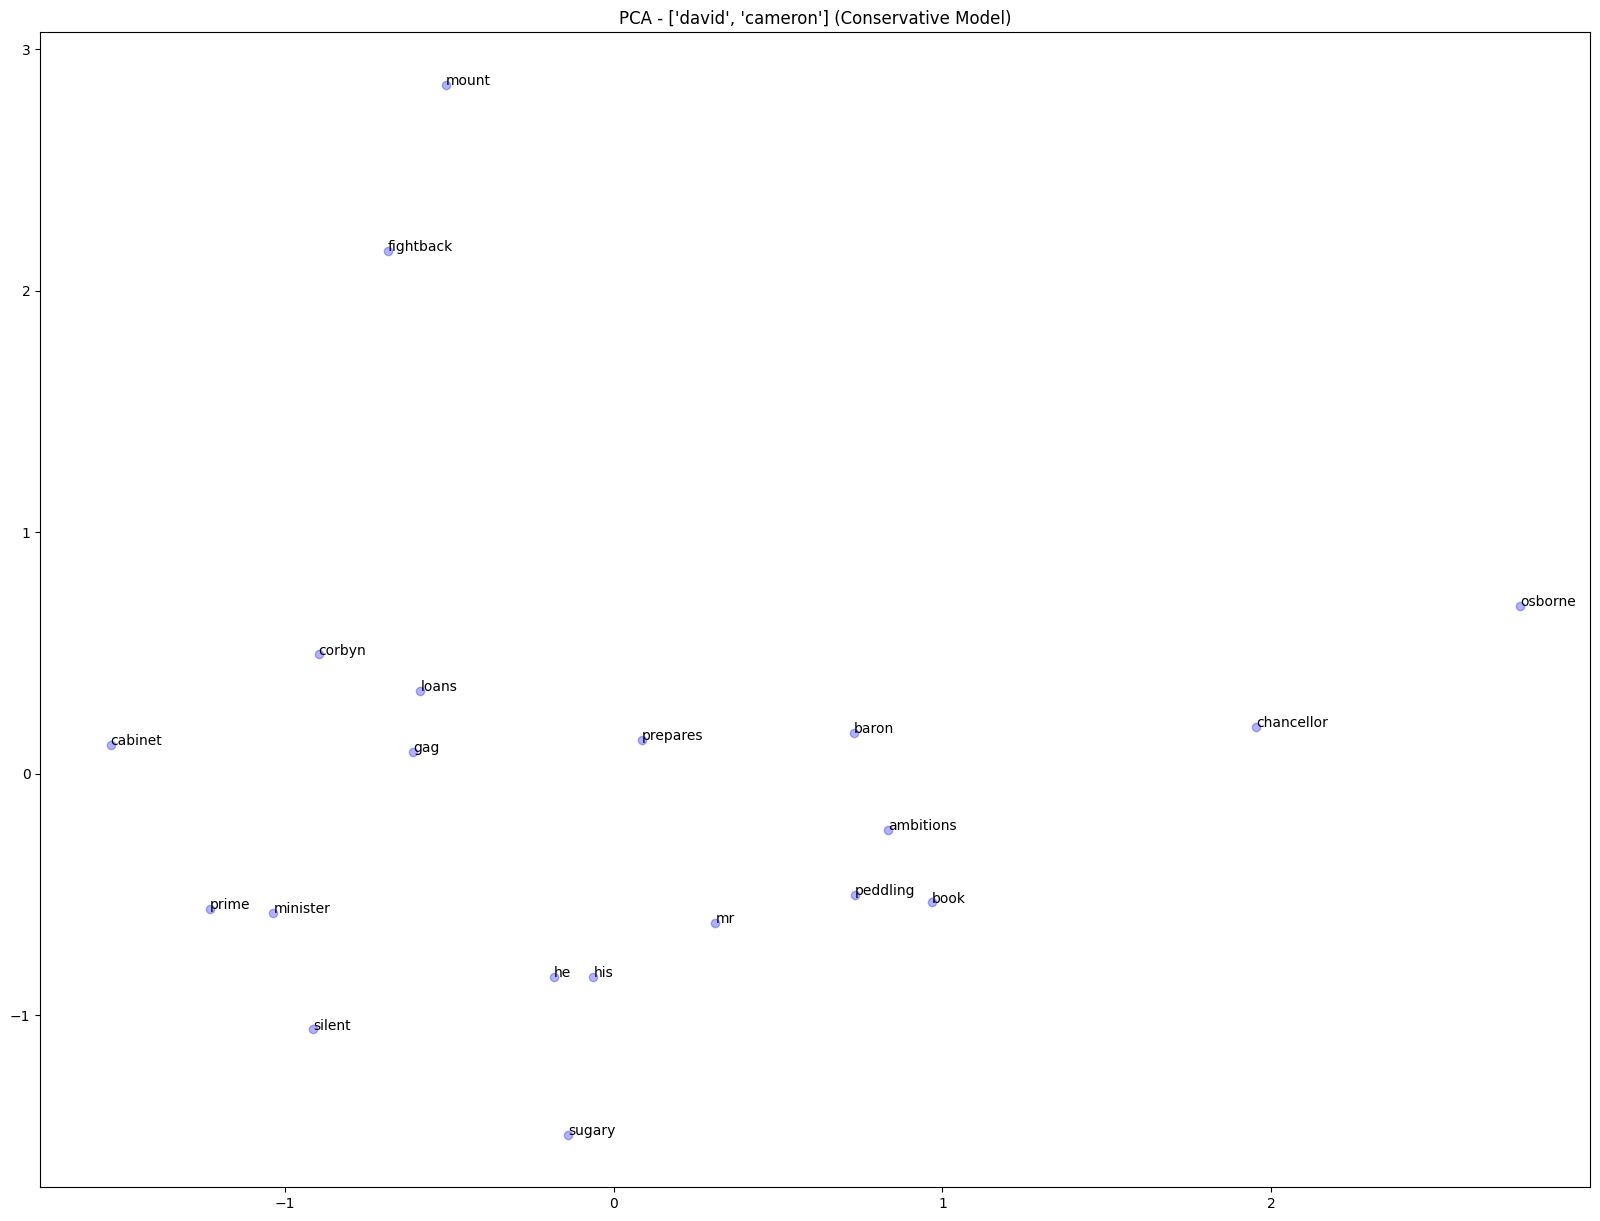

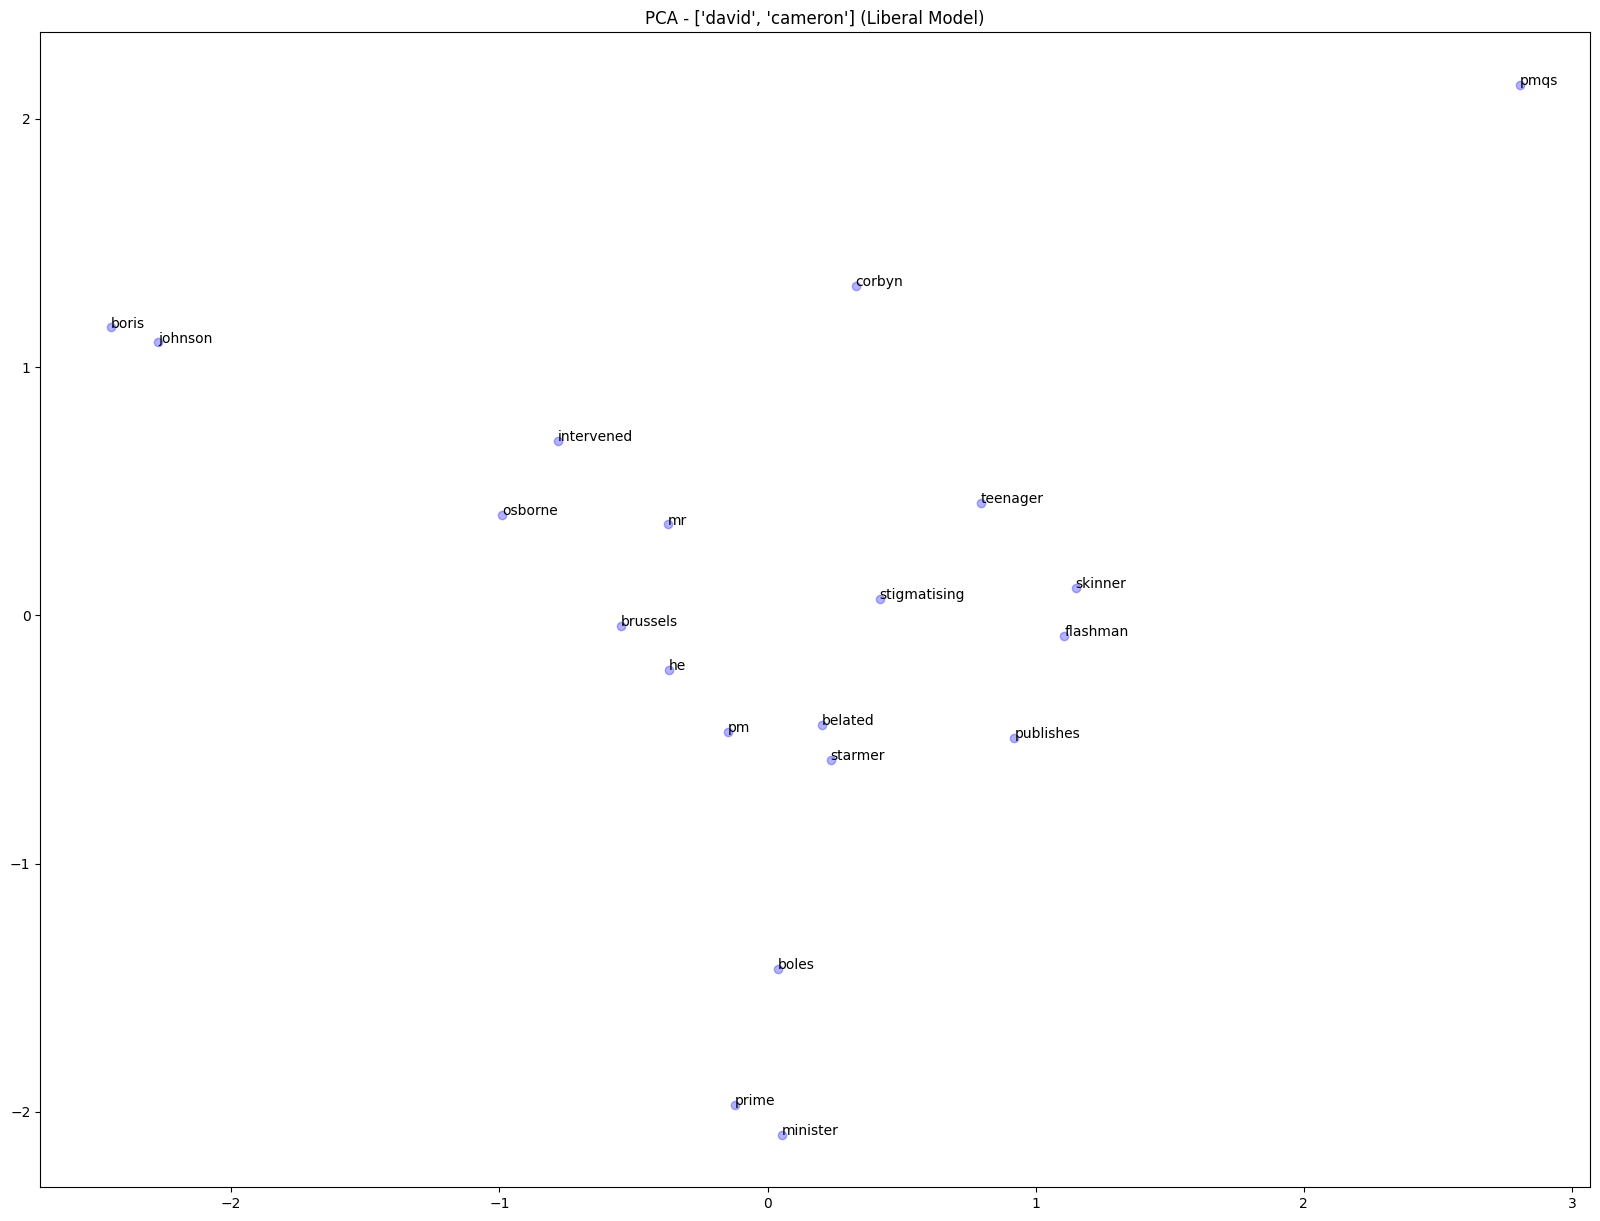

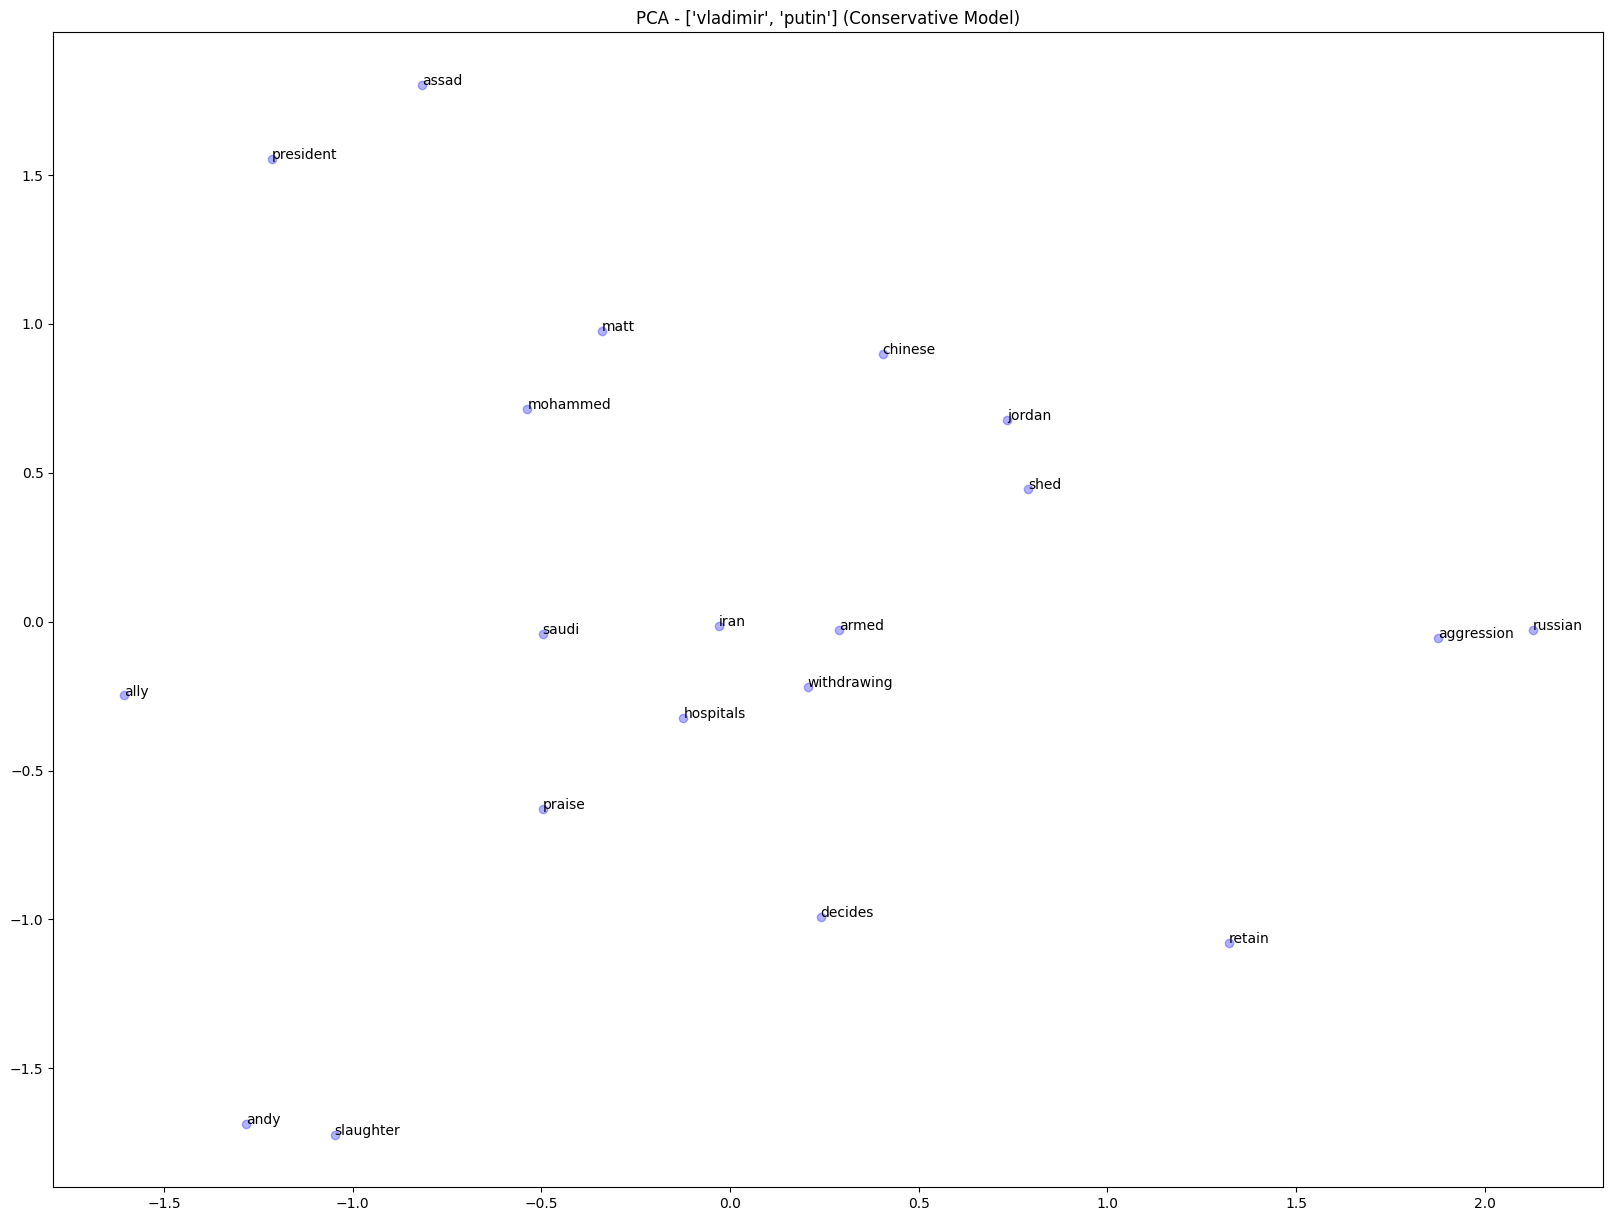

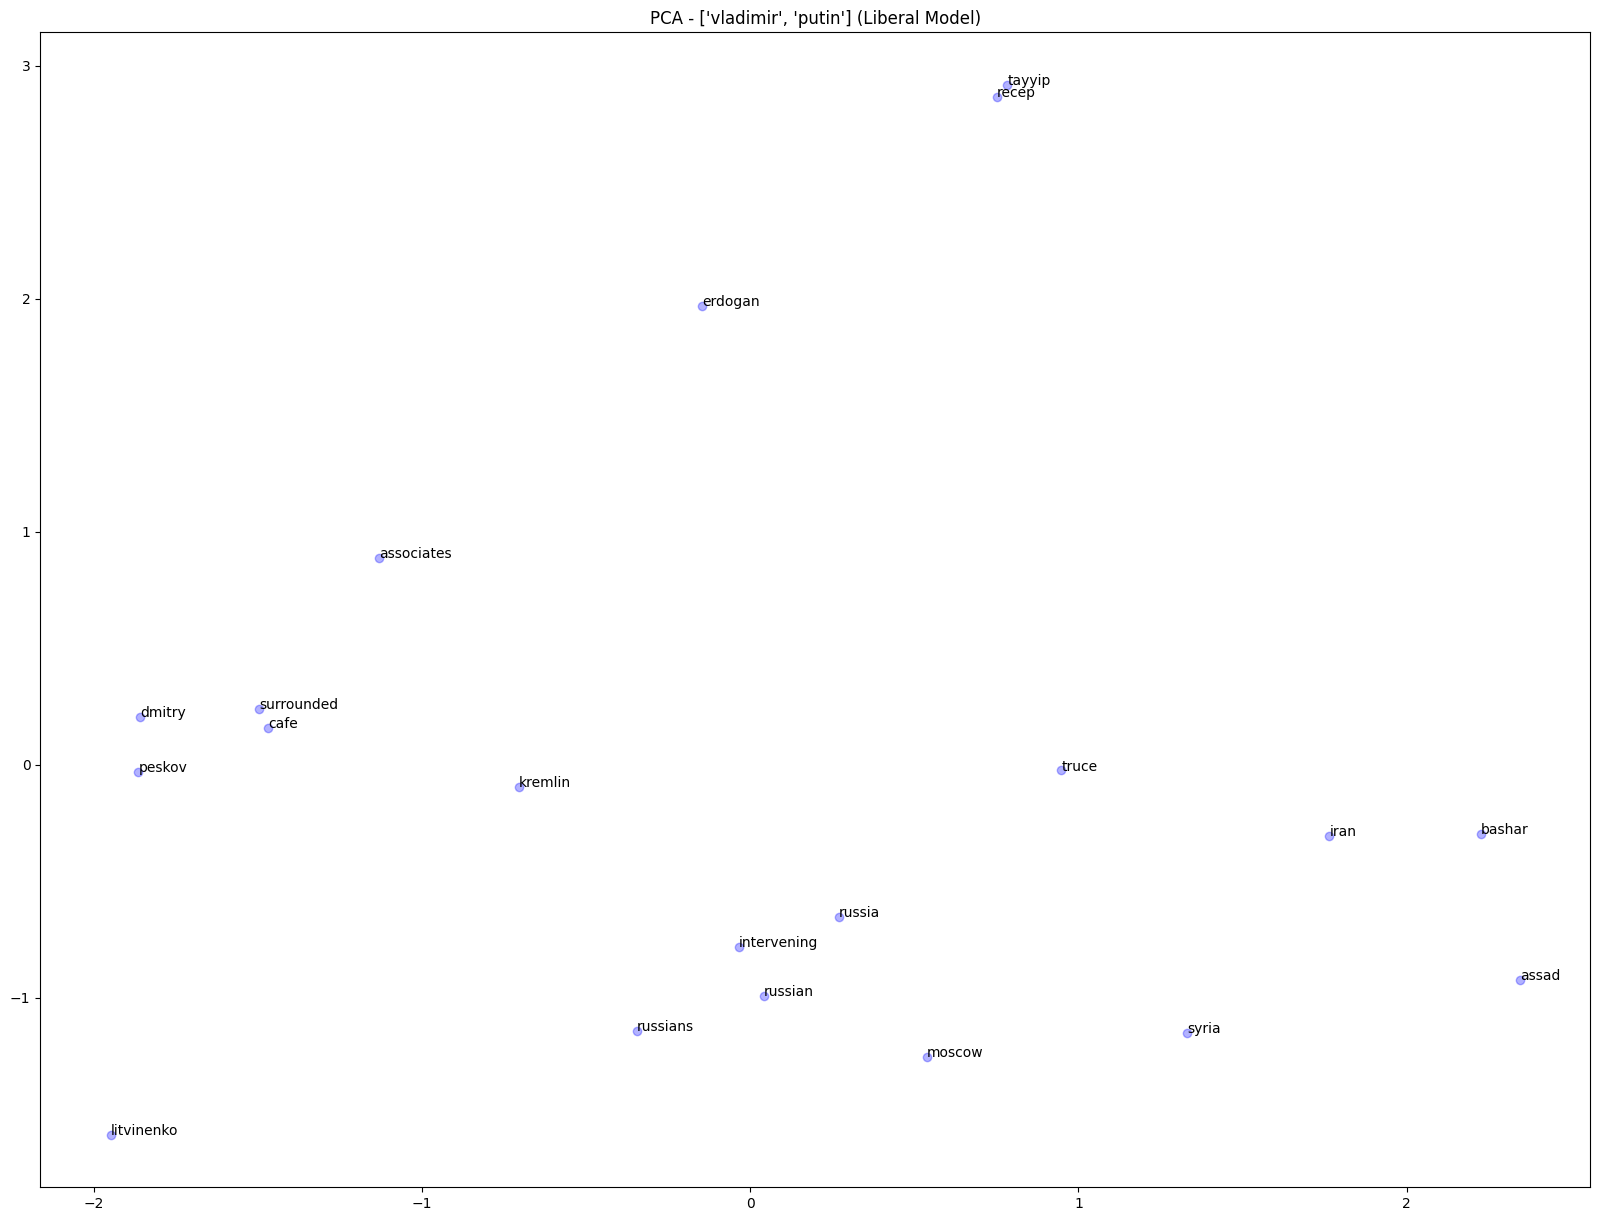

In [21]:
# Plot liberal and conservative neighbors for each person
for person in persons:
    person = person.lower().split()
    cons_nbor = get_k_nearest_neighbors(person, w2v_model_cons, k=20)
    lib_nbor = get_k_nearest_neighbors(person, w2v_model_lib, k=20)


    cons_person_vec = w2v_model_cons.wv[person]
    cons_nbors_vec = [w2v_model_cons.wv[word] for word in cons_nbor]
    lib_person_vec = w2v_model_lib.wv[person]
    lib_nbors_vec = [w2v_model_lib.wv[word] for word in lib_nbor]

    cons_person_pca = apply_pca(np.vstack(cons_nbors_vec))
    lib_person_pca = apply_pca(np.vstack(lib_nbors_vec))

    plot_pca(cons_person_pca, cons_nbor, f'PCA - {person} (Conservative Model)')
    plot_pca(lib_person_pca, lib_nbor, f'PCA - {person} (Liberal Model)')


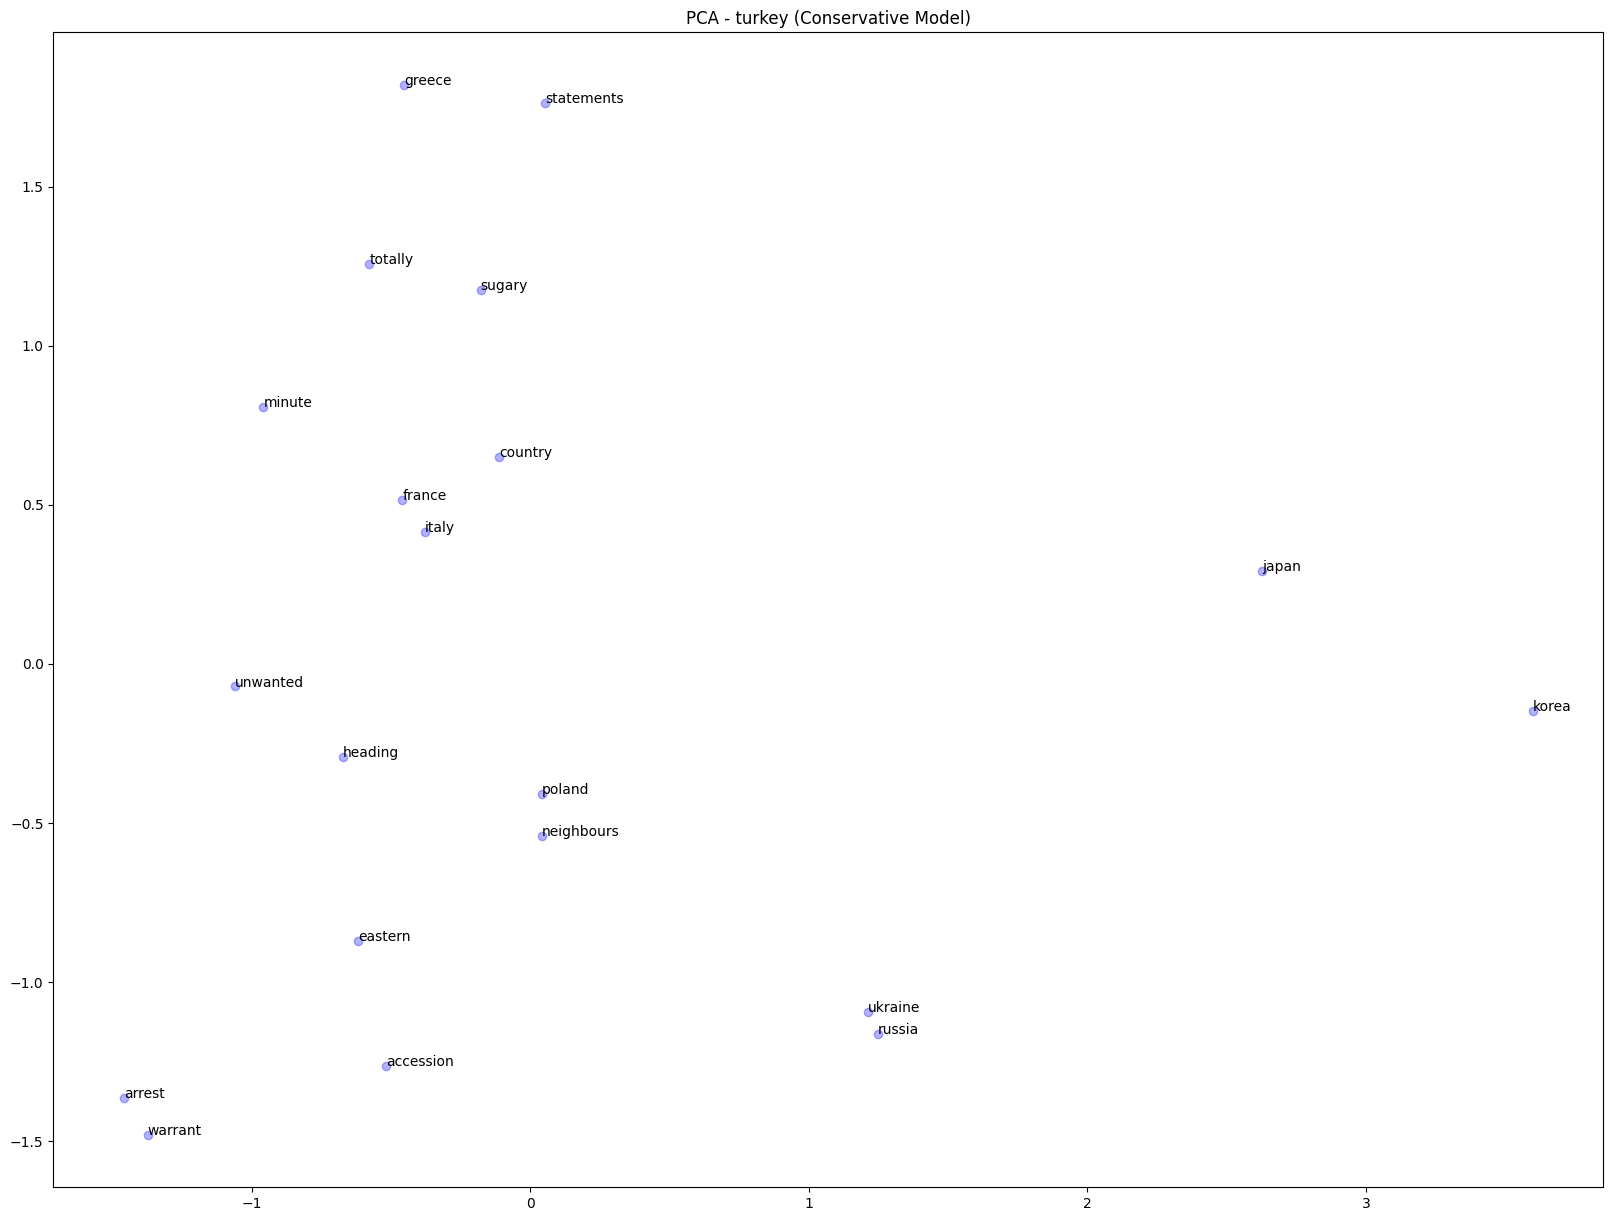

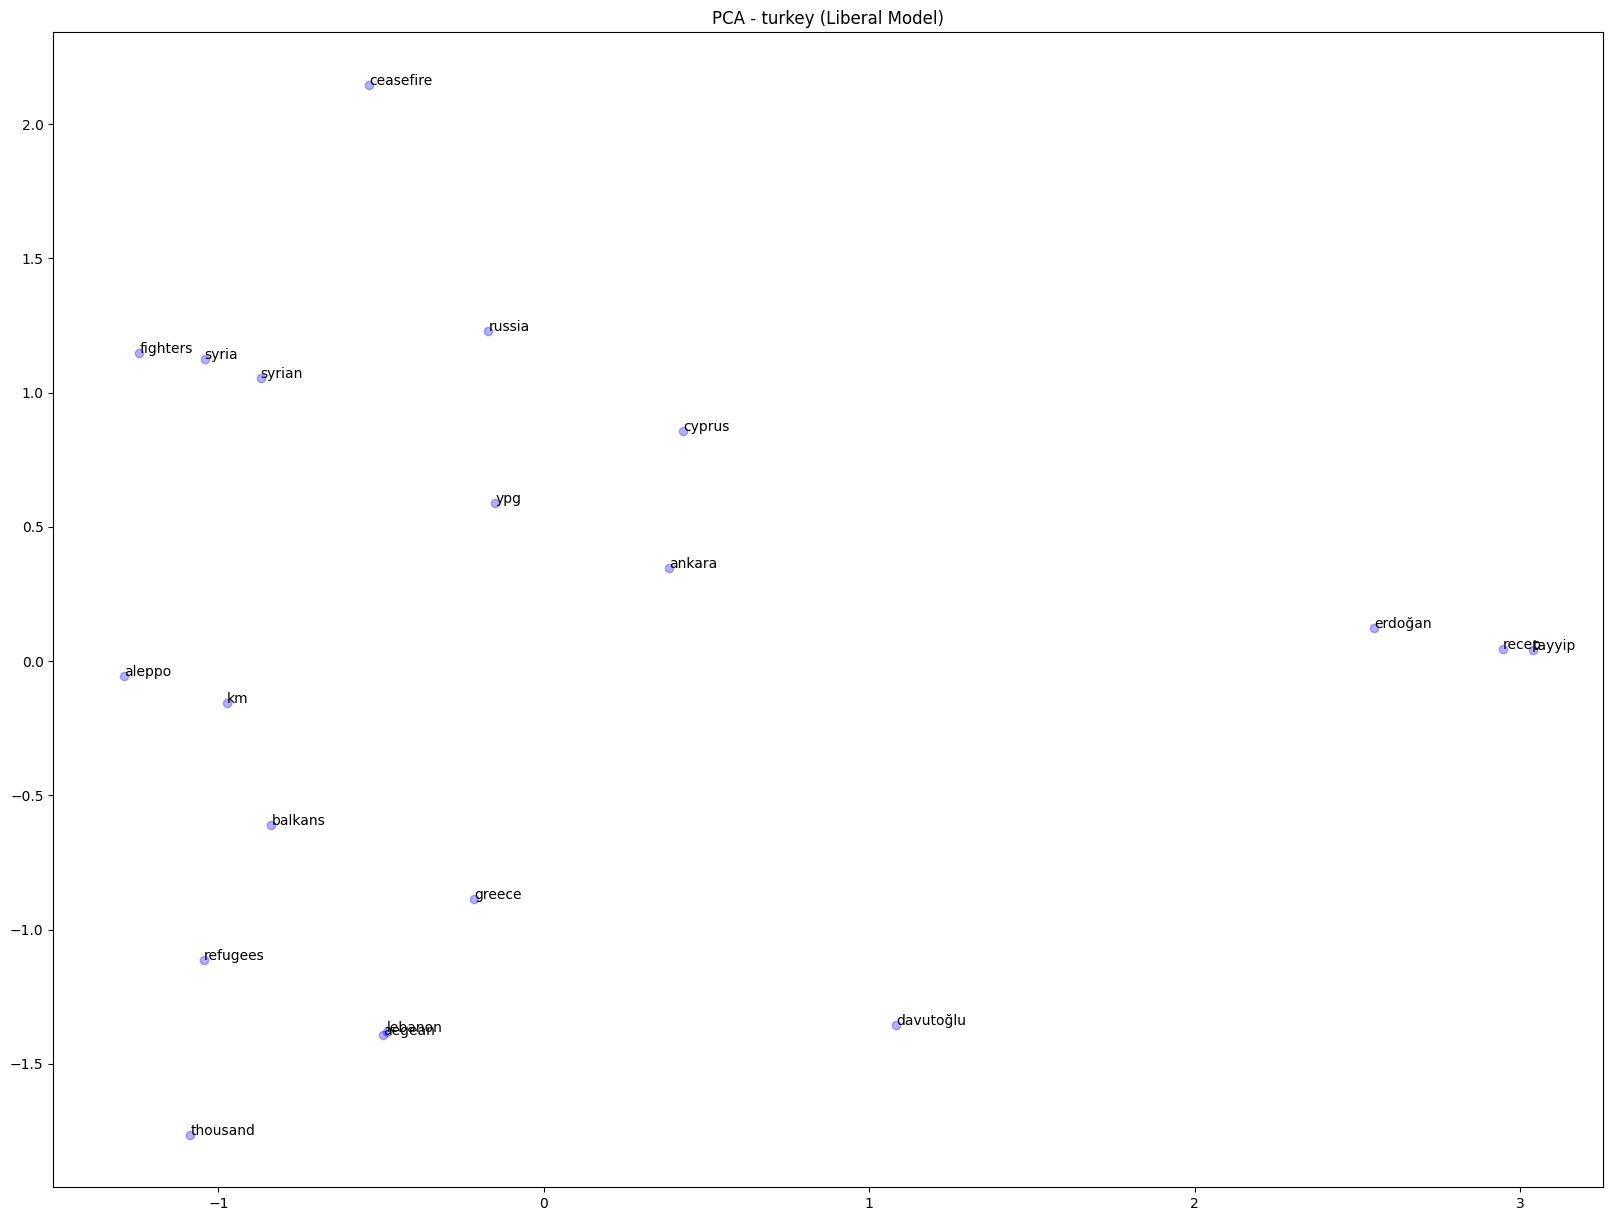

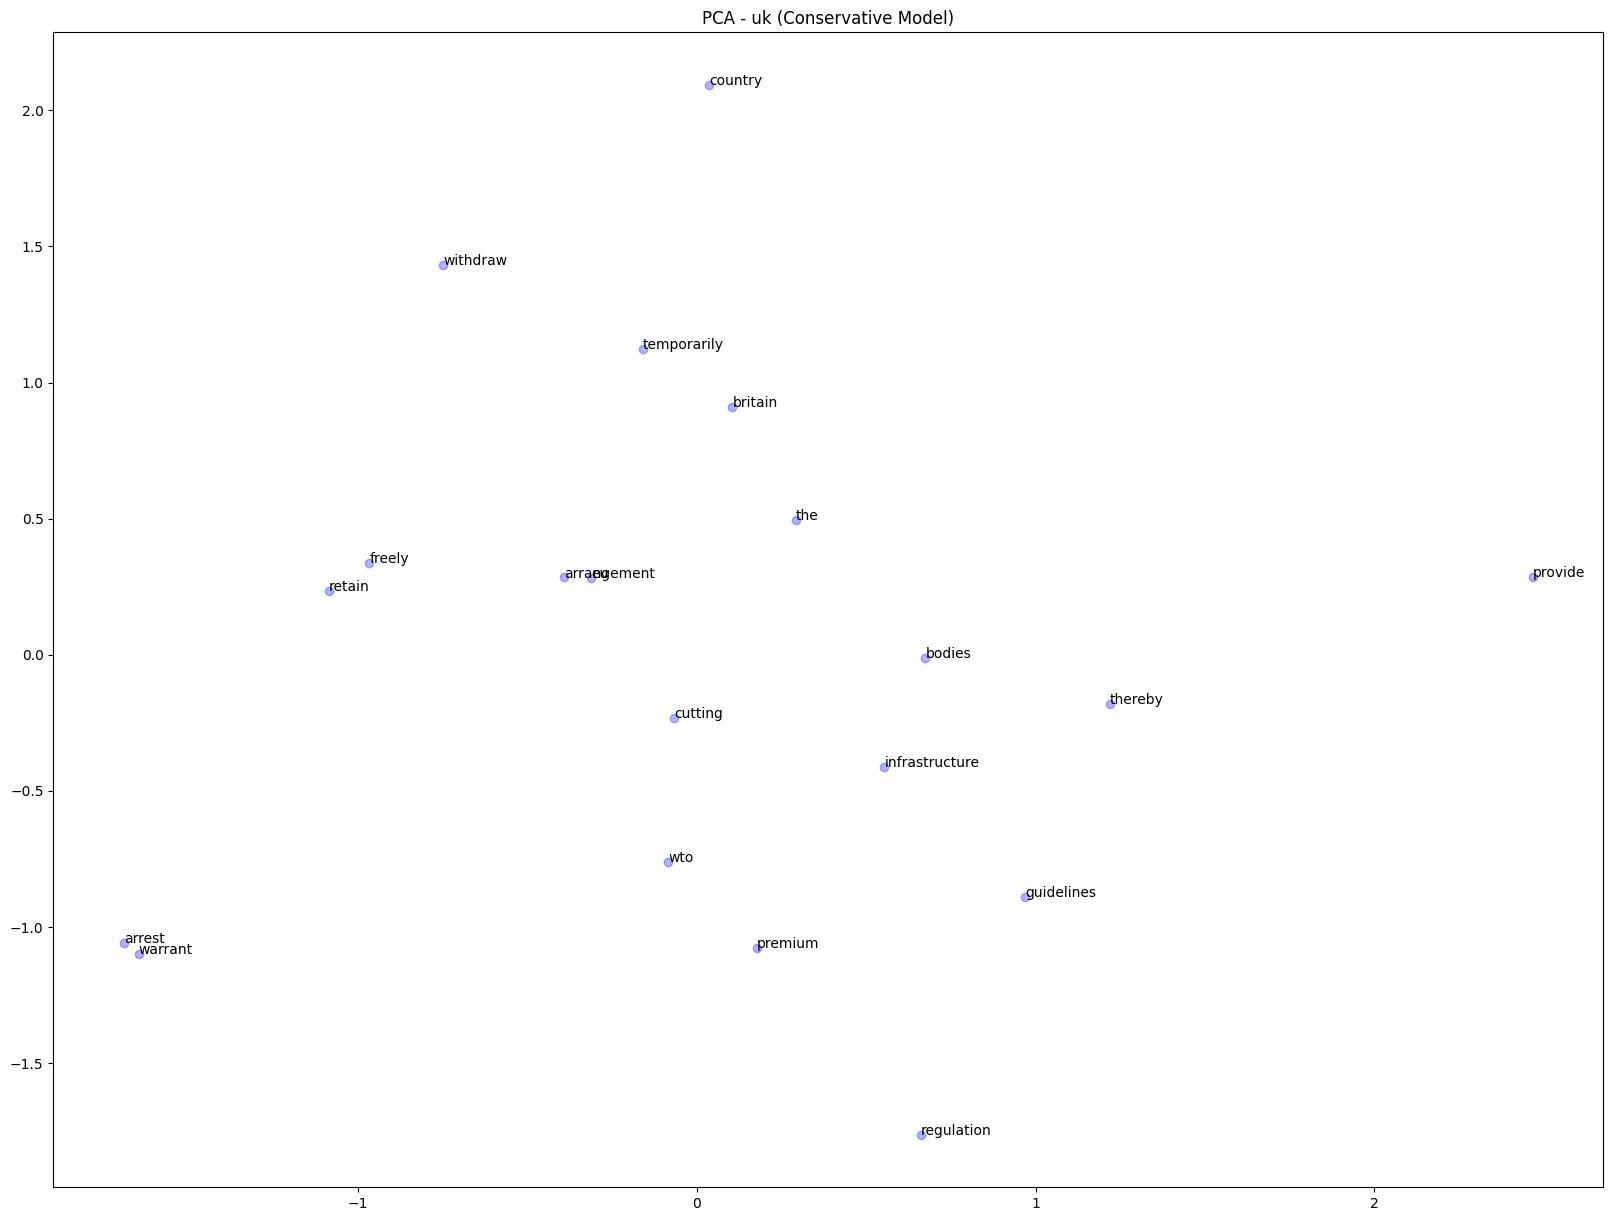

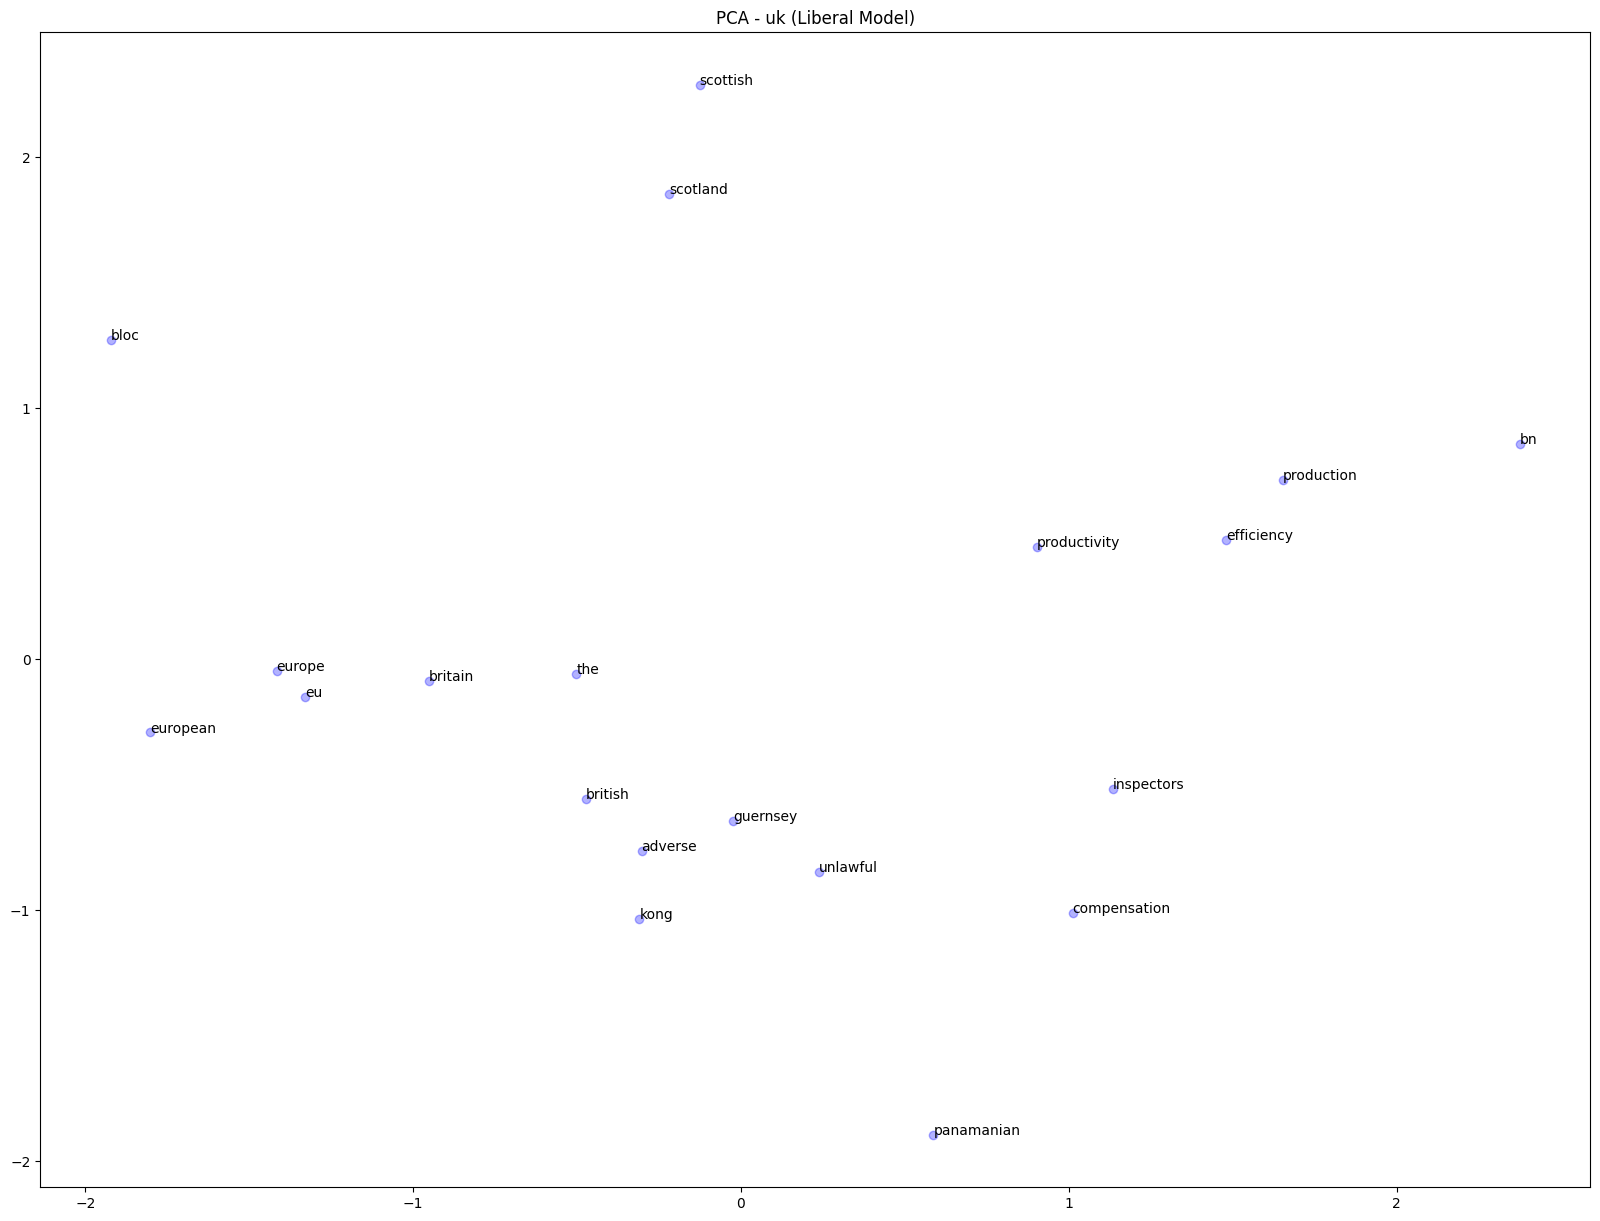

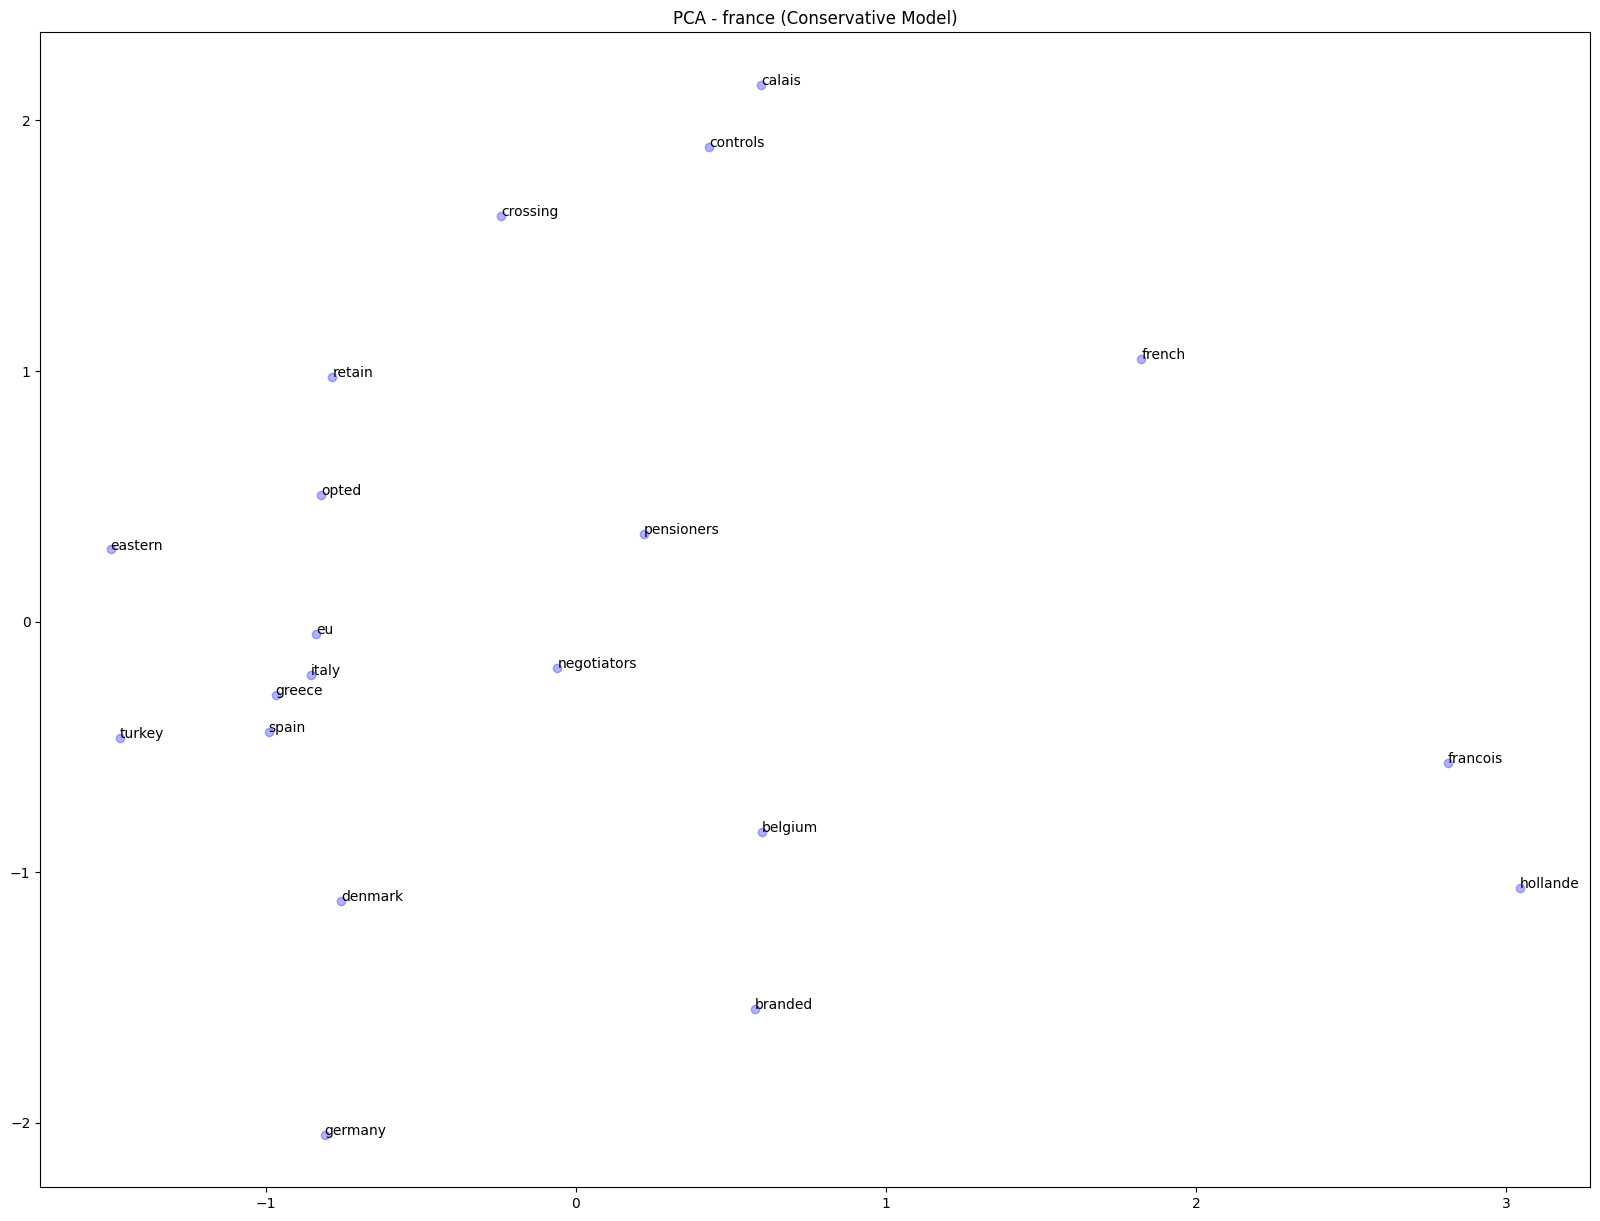

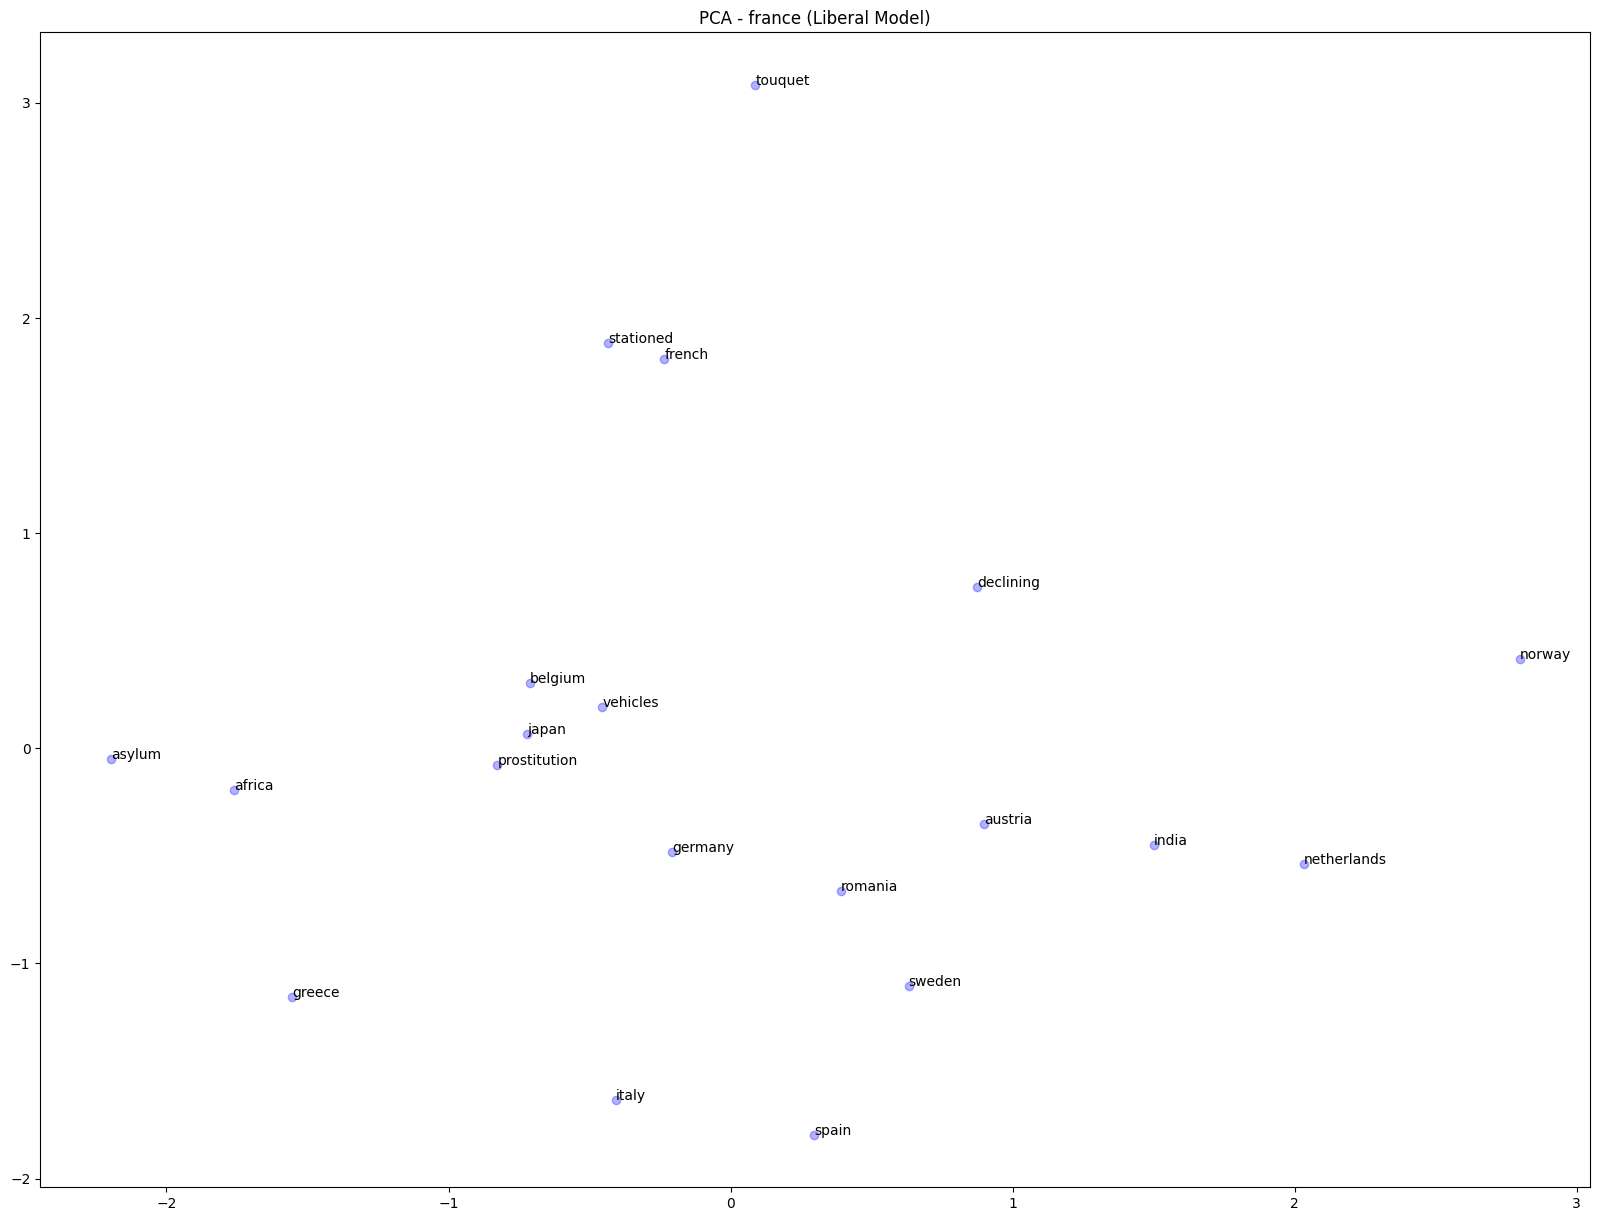

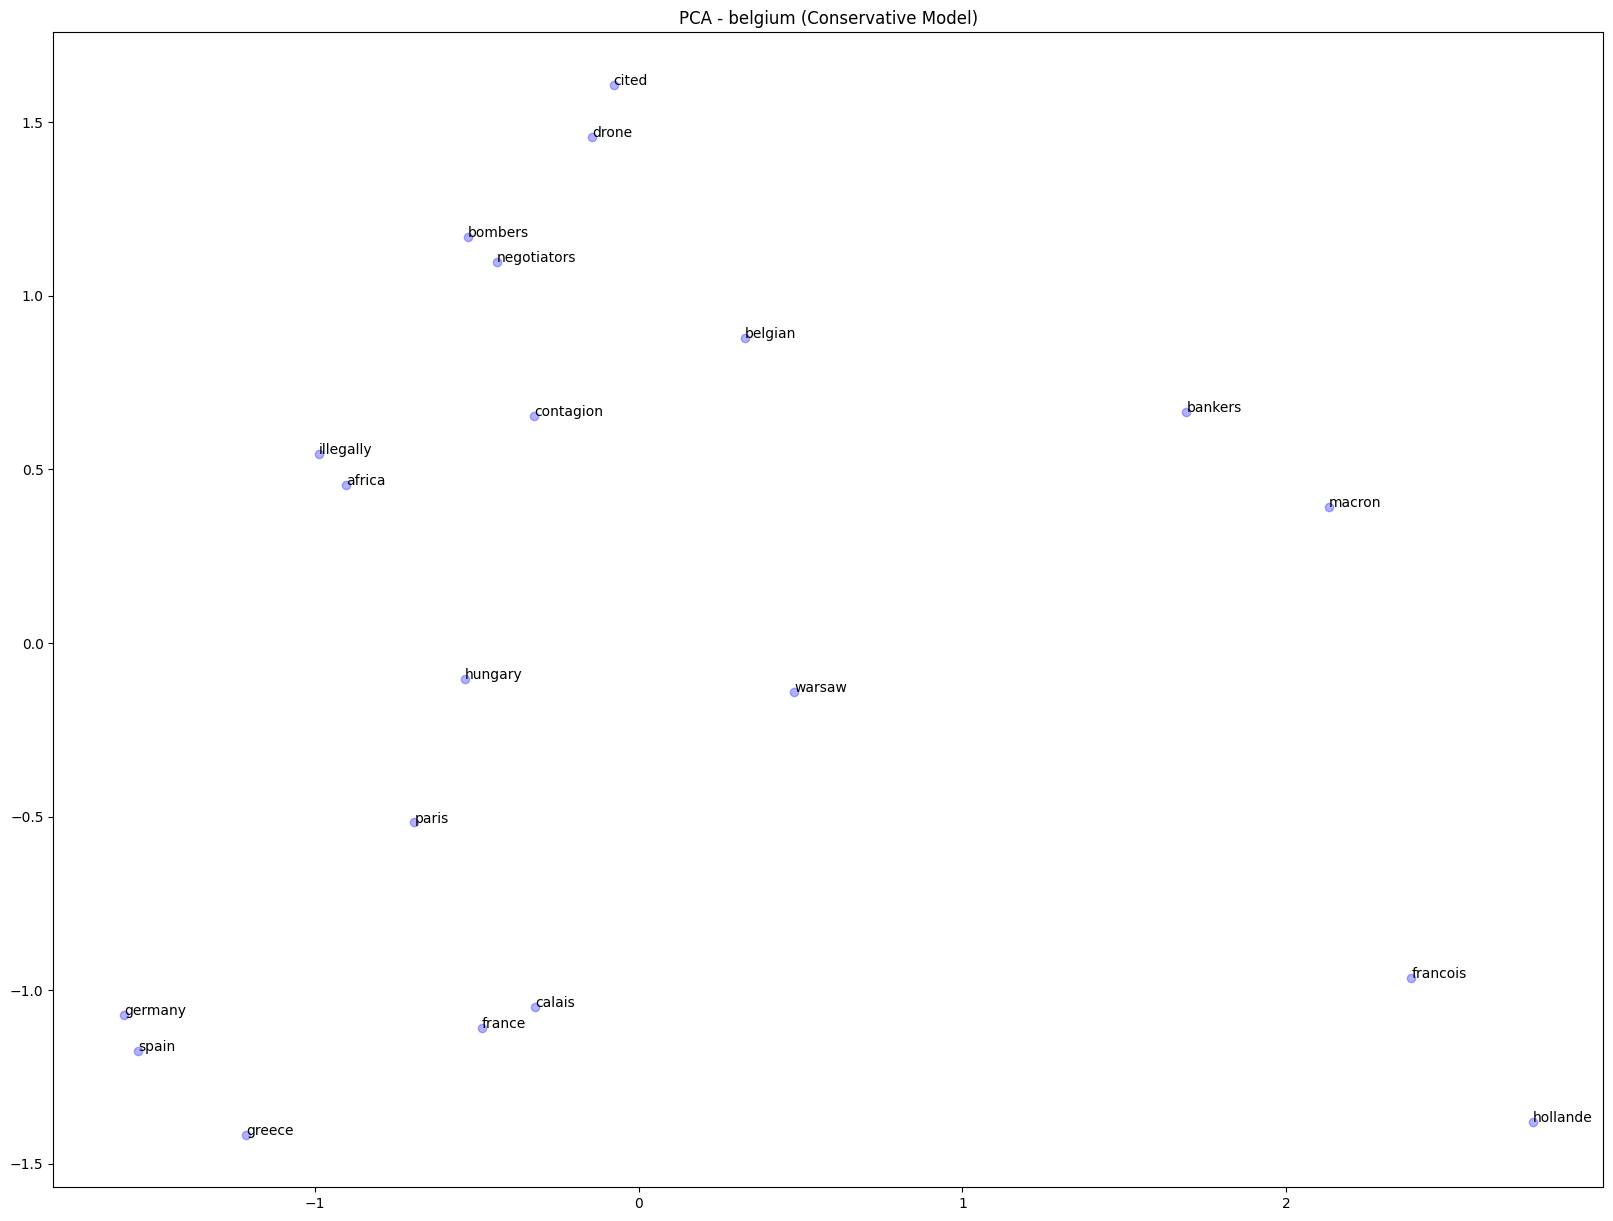

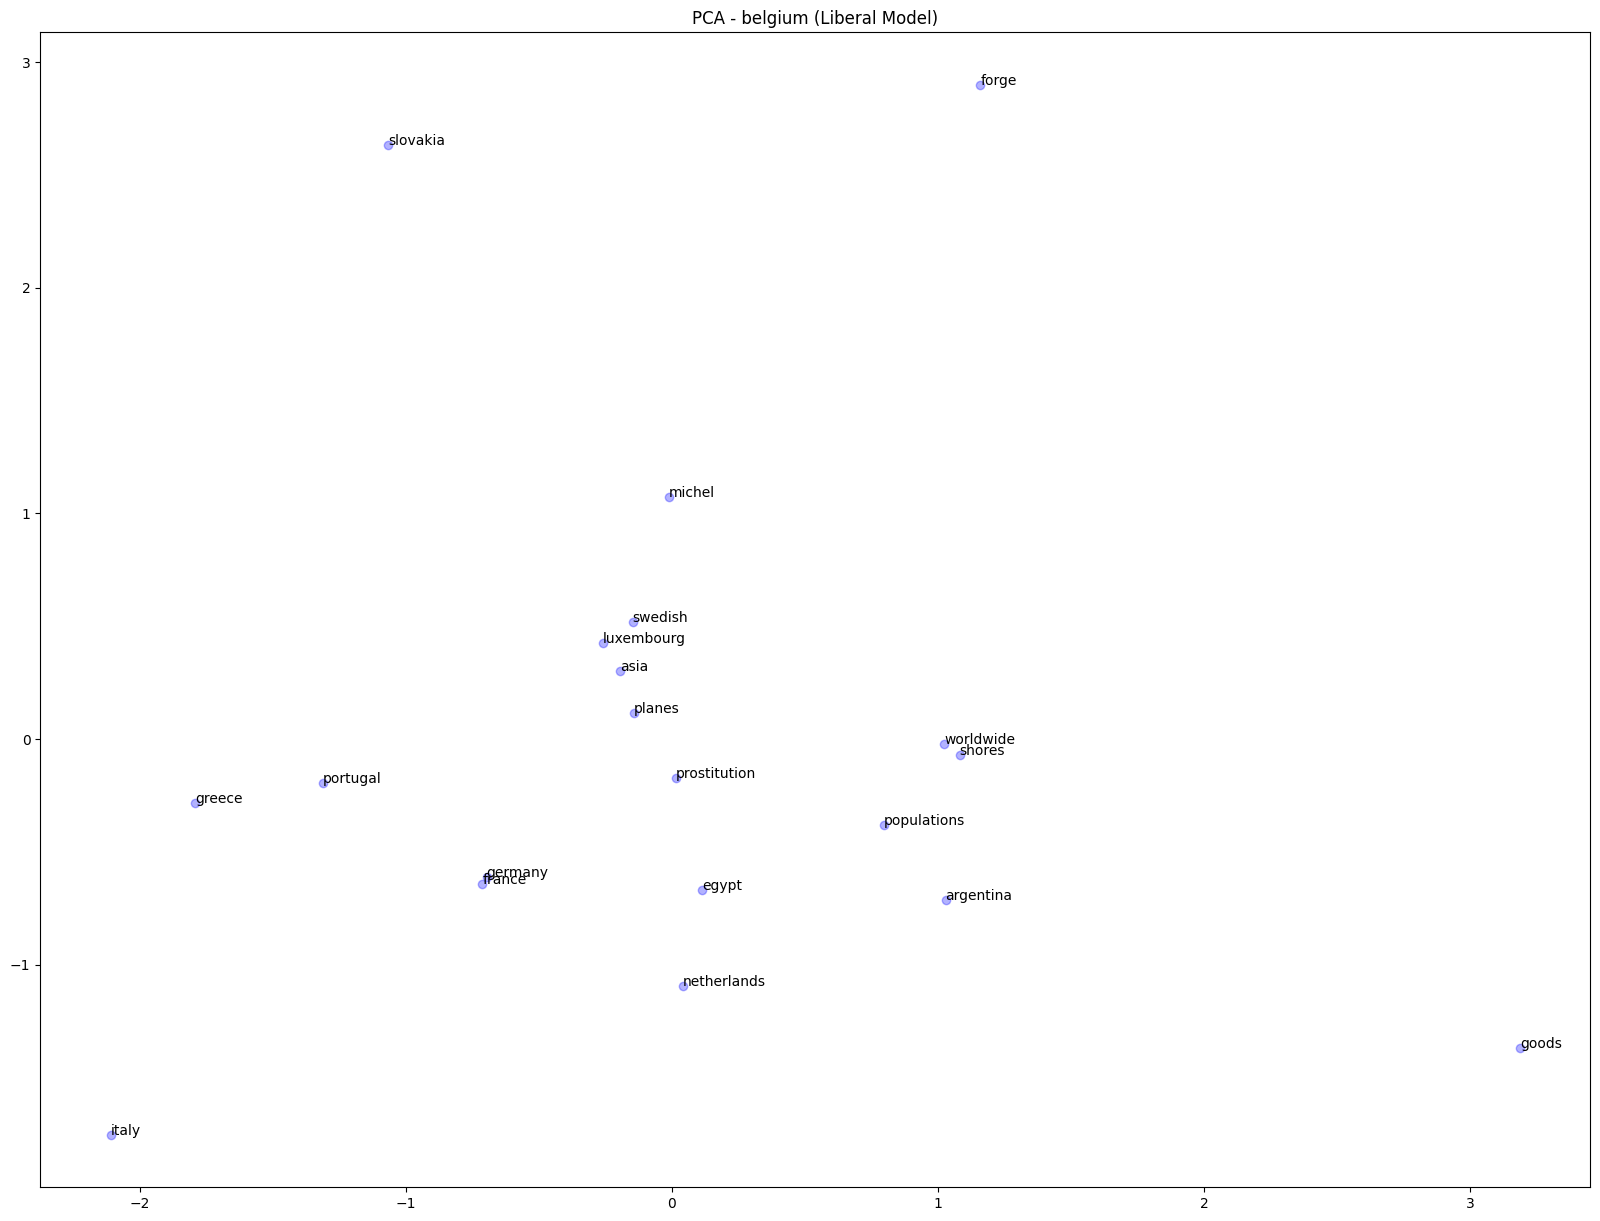

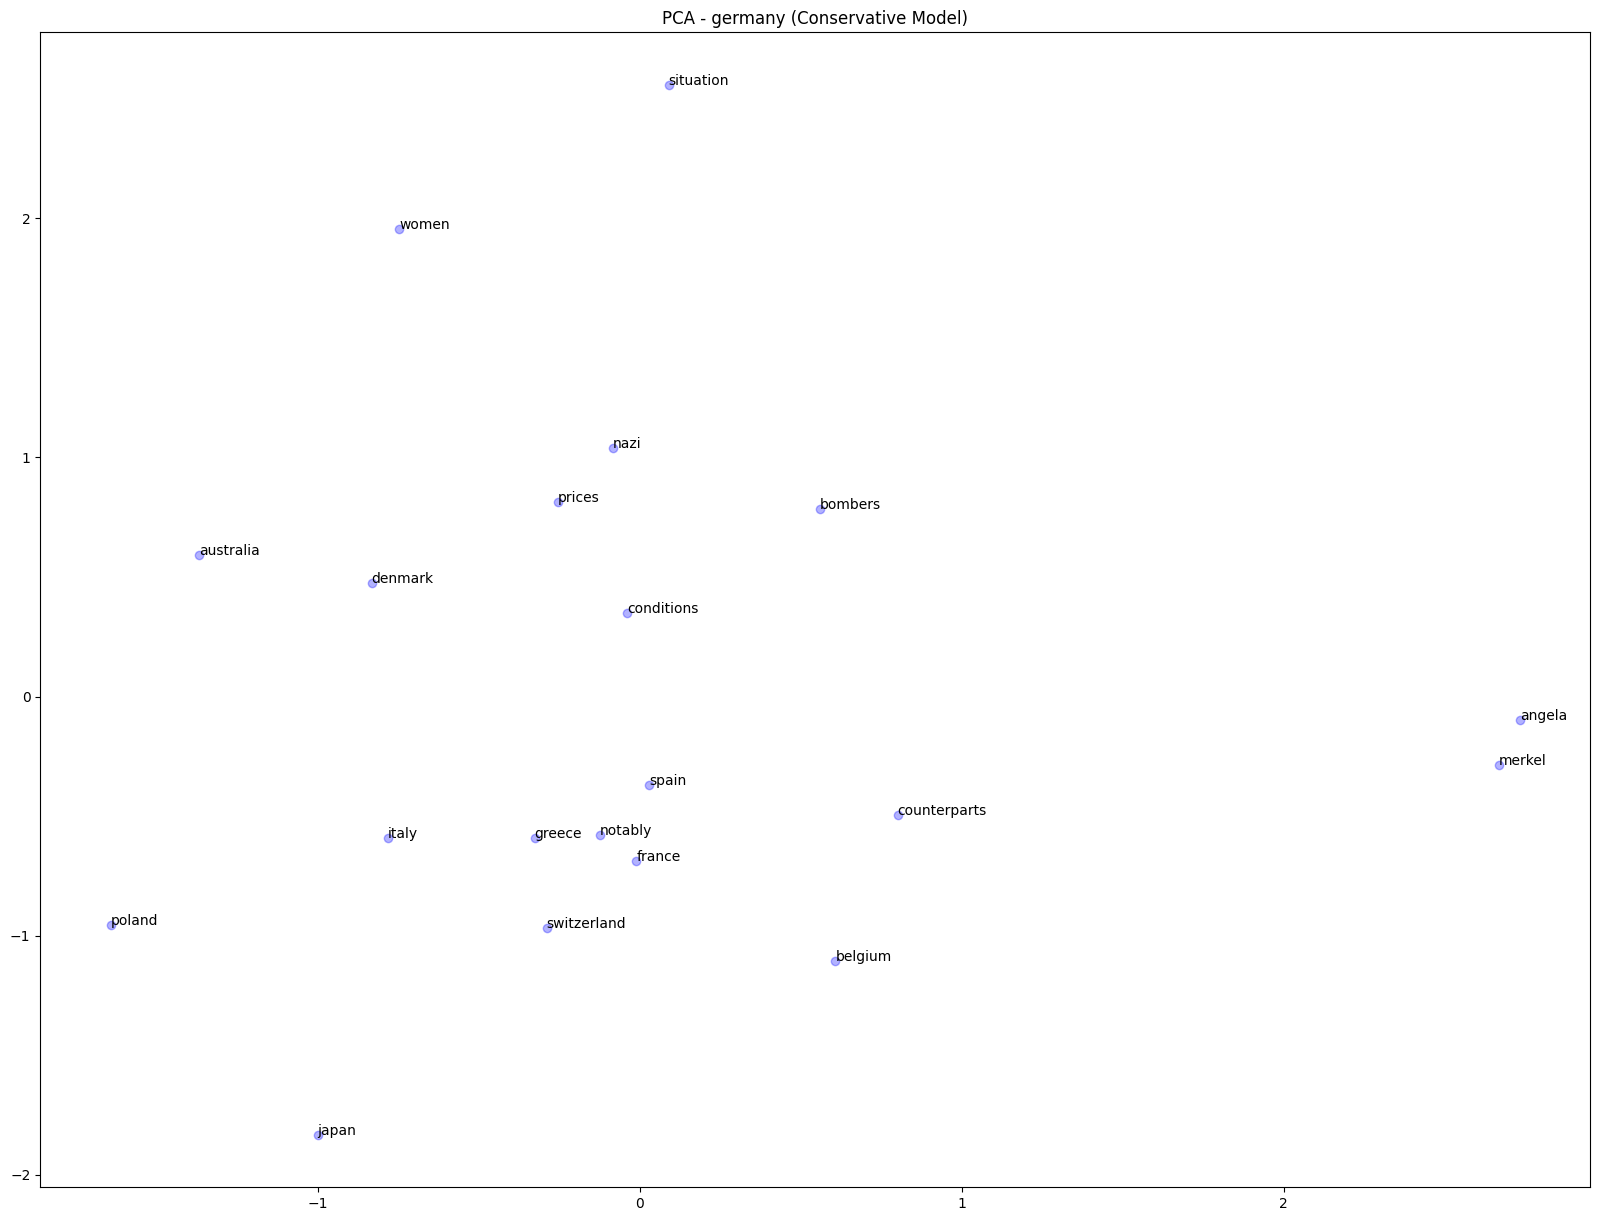

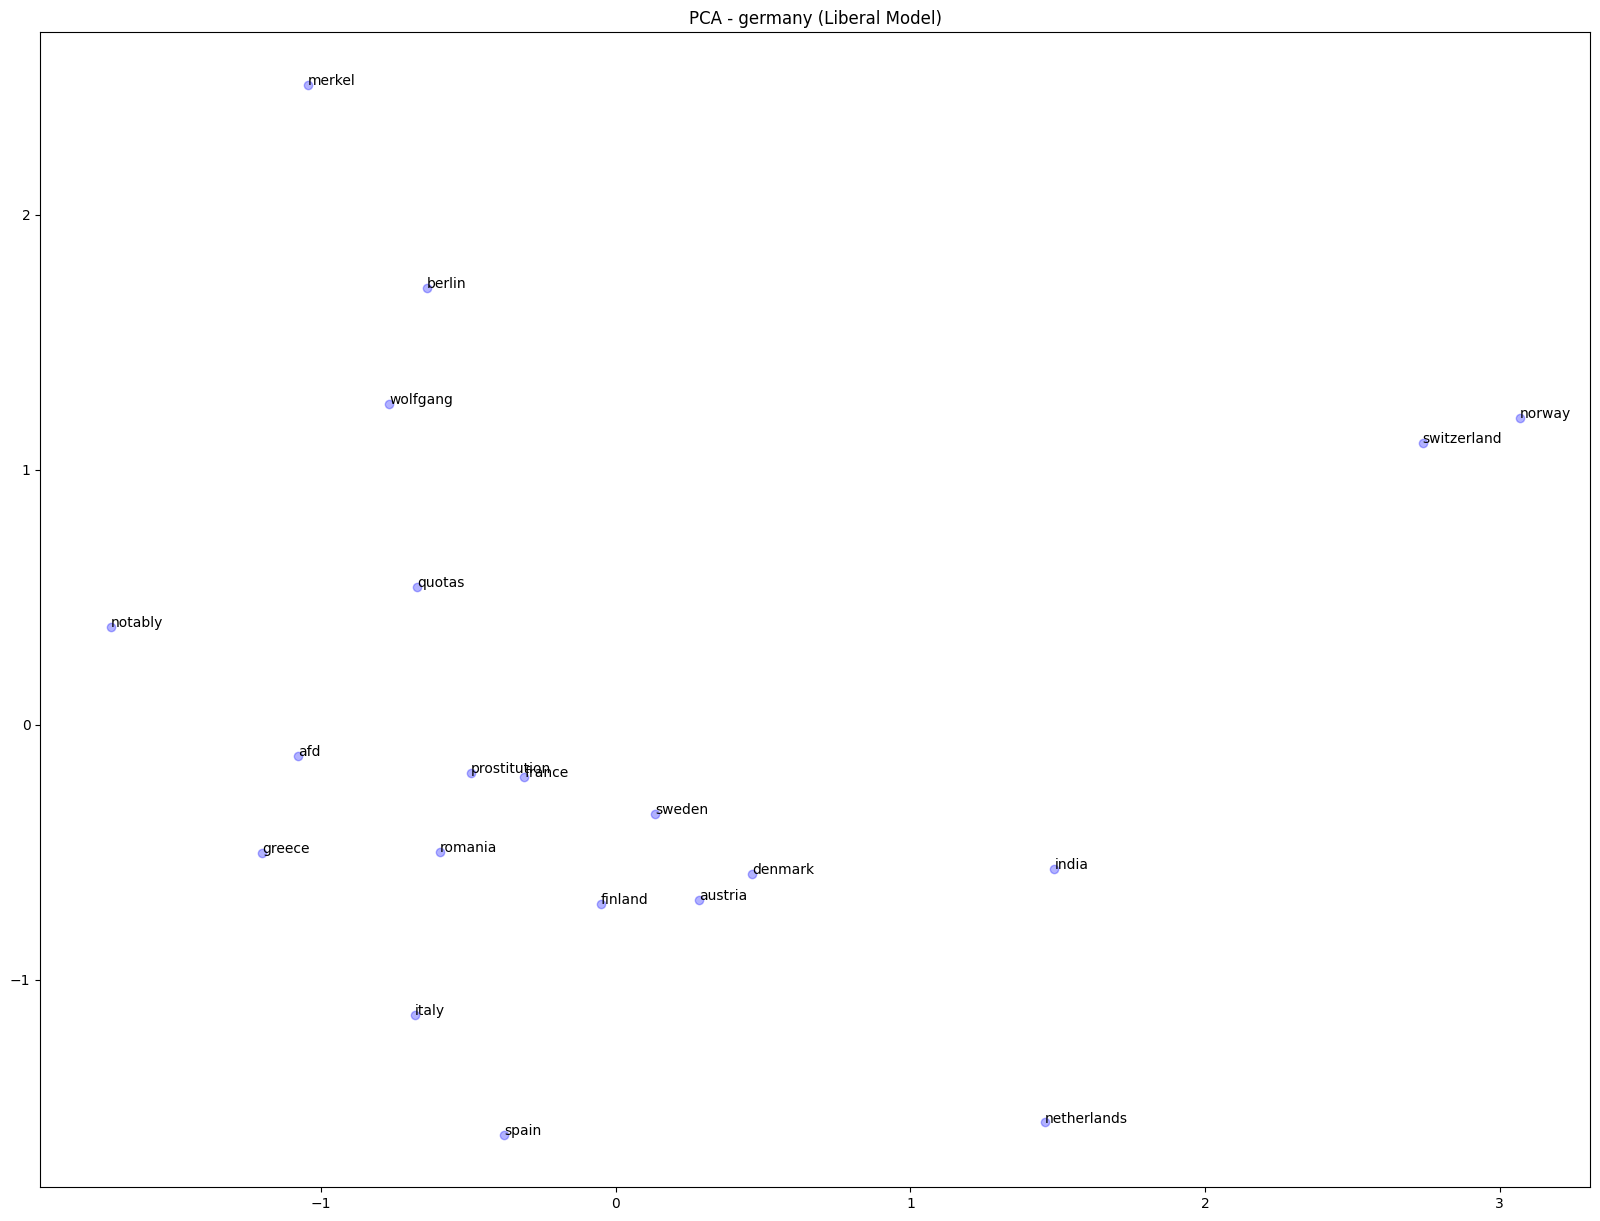

In [22]:
# Plot liberal and conservative neighbors for each country
countries_names = ["Turkey", "UK", "France", "Belgium", "Germany"]
for country in countries_names:
    country = country.lower()
    cons_nbor = get_k_nearest_neighbors(country, w2v_model_cons, k=20)
    lib_nbor = get_k_nearest_neighbors(country, w2v_model_lib, k=20)


    cons_person_vec = w2v_model_cons.wv[country]
    cons_nbors_vec = [w2v_model_cons.wv[word] for word in cons_nbor]
    lib_person_vec = w2v_model_lib.wv[country]
    lib_nbors_vec = [w2v_model_lib.wv[word] for word in lib_nbor]

    cons_person_pca = apply_pca(np.vstack(cons_nbors_vec))
    lib_person_pca = apply_pca(np.vstack(lib_nbors_vec))

    plot_pca(cons_person_pca, cons_nbor, f'PCA - {country} (Conservative Model)')
    plot_pca(lib_person_pca, lib_nbor, f'PCA - {country} (Liberal Model)')


In [25]:
# Print Dataframes
table = []
for person in persons:
    person_low = person.lower().split()
    cons_nbor = get_k_nearest_neighbors(person_low, w2v_model_cons, k=20)
    lib_nbor = get_k_nearest_neighbors(person_low, w2v_model_lib, k=20)


    sim_cons = [(nbor, w2v_model_cons.wv.n_similarity(person_low, [nbor])) for nbor in cons_nbor]
    sim_lib = [(nbor, w2v_model_lib.wv.n_similarity(person_low, [nbor])) for nbor in lib_nbor]



    sim_cons.sort(key=lambda x: x[1], reverse=True)
    sim_lib.sort(key=lambda x: x[1], reverse=True)

    table.append({
        'Entity': person,
        'Conservative Model Similarities': sim_cons,
        'Liberal Model Similarities': sim_lib
    })

for result in table:
    entity = result['Entity']
    df_conservative = pd.DataFrame(result['Conservative Model Similarities'], columns=['Neighbor', 'Similarity (Conservative)'])
    df_liberal = pd.DataFrame(result['Liberal Model Similarities'], columns=['Neighbor', 'Similarity (Liberal)'])

    print(f"\nRanked Similarities for {entity}:\n")
    print("Conservative Model:")
    print(df_conservative)

    print("\nLiberal Model:")
    print(df_liberal)


Ranked Similarities for Donald Trump:

Conservative Model:
        Neighbor  Similarity (Conservative)
0           cruz                   0.614494
1     republican                   0.588684
2    billionaire                   0.586729
3         queens                   0.573865
4         runner                   0.556171
5   battleground                   0.553450
6          texas                   0.548425
7           grew                   0.542330
8            gov                   0.531126
9            ted                   0.525287
10   lewandowski                   0.523898
11           gop                   0.518817
12       whining                   0.518731
13   comfortable                   0.516466
14         marco                   0.513032
15     wisconsin                   0.511532
16        badger                   0.511236
17      christie                   0.509742
18          ohio                   0.503313
19       nominee                   0.496685

Liberal Model:


In [26]:
# Print Dataframes
table = []
for country in countries_names:
    country_low = country.lower()
    cons_nbor = get_k_nearest_neighbors(country_low, w2v_model_cons, k=20)
    lib_nbor = get_k_nearest_neighbors(country_low, w2v_model_lib, k=20)


    sim_cons = [(nbor, w2v_model_cons.wv.similarity(country_low, nbor)) for nbor in cons_nbor]
    sim_lib = [(nbor, w2v_model_lib.wv.similarity(country_low, nbor)) for nbor in lib_nbor]



    sim_cons.sort(key=lambda x: x[1], reverse=True)
    sim_lib.sort(key=lambda x: x[1], reverse=True)

    table.append({
        'Entity': country,
        'Conservative Model Similarities': sim_cons,
        'Liberal Model Similarities': sim_lib
    })

for result in table:
    entity = result['Entity']
    df_conservative = pd.DataFrame(result['Conservative Model Similarities'], columns=['Neighbor', 'Similarity (Conservative)'])
    df_liberal = pd.DataFrame(result['Liberal Model Similarities'], columns=['Neighbor', 'Similarity (Liberal)'])

    print(f"\nRanked Similarities for {entity}:\n")
    print("Conservative Model:")
    print(df_conservative)

    print("\nLiberal Model:")
    print(df_liberal)


Ranked Similarities for Turkey:

Conservative Model:
      Neighbor  Similarity (Conservative)
0       greece                   0.492367
1        japan                   0.485708
2        korea                   0.478371
3   statements                   0.464736
4      eastern                   0.464144
5        italy                   0.463786
6       russia                   0.463607
7       france                   0.461535
8      ukraine                   0.460582
9     unwanted                   0.443251
10  neighbours                   0.436706
11      poland                   0.430110
12      minute                   0.428949
13     heading                   0.421156
14      arrest                   0.420809
15     warrant                   0.418764
16      sugary                   0.418471
17   accession                   0.418237
18     totally                   0.417940
19     country                   0.414842

Liberal Model:
     Neighbor  Similarity (Liberal)
0      greec